#### **Introduction**

In the last few years, several cities across the world have experienced an explosive growth in Airbnb. What started as a shared economy platform for informal home-sharing has recently transformed into a major short-term rental market which fills the gap between traditional residential rental housing and hotel accommodation (Giovanni). While Airbnb advocates argue that the platform brings extra incomes to its users and new economic activities to cities, many raise concerns about its impact on housing markets through loss of housing supply, increased rent and gentrification (NYC, gentrification).

This report is motivated by claims that Airbnb is ‘out of control’ in London, and specifically addresses the recent proposal to force all professional landlords operating on the platform to register their properties and face higher Council Tax rates. Using comprehensive empirical analysis, we aim to answer five questions:

1.	Is Airbnb ‘out of control’ in London?
2.	How many professional landlords are there?
3.	How many properties would be affected by the proposal?
4.	What are the likely pros and cons of the proposal (for the Mayor, residents, and the city)?
5.	Can the story be reframed as a positive one about social mobility or housing opportunity?

Our investigation uses the Inside Airbnb (IA) dataset to analyse Airbnb activity for more than **xxx** million listings in London. To determine the impact of Airbnb on the housing market, we use average monthly rents in private rental market aggregated at the borough level. The potential impact of introducing higher Council Tax rates to professional landlords is explored using Council Tax data at the borough level.


#### Data and methodologies

Our investigation relies heavily on the Inside Airbnb dataset, which scrapes publicly available listing information from the Airbnb platform. The Inside Airbnb dataset is commonly used in research, presumably because it is one of the only publicly-accessible datasets currently available. However, it is not without serious limitations which need consideration. Importantly, the dataset acts as a snapshot of listing information as it appeared on the day of scraping, making much of the data unreliable because the host could change these inputs (such as price and minimum-stay requirements) at any given moment. In 2015, Airbnb stopped disclosing the difference between nights that are booked by guests and nights that are ‘blacked-out’ by hosts, making it impossible to precisely measure occupancy and revenue (NYC). Where assumptions are made, our findings provide conservative estimates for occupancy and revenue – these values are likely much higher. 


Other **limitations** that might need discussing (depending on how many words we have at the end):
- "Although each Airbnb listing is specified on the public Airbnb website with exact latitude and longitude coordinates, these coordinates have been shifted from the real location by up to 150m in a random direction (in order to protect hosts’ privacy). This randomness means that maps which show the exact locations of listings (or rely on these locations for their analyses) are misleading inasmuch as they exaggerate the precision of the underlying spatial data." - NYC paper

In [1]:
# --- Part 01 Data Loading ---
# The Work Mythology in Part 01 Data Loading and Initial Cleaning:
# Steps:
# 1) Import Packages
# 2) Ensuring Folder Structure, a main file named data, and subfolders: Raw and Clean.
# 3) Download files from the Web into a raw file in the home repository
# 4) Additional Data loading, such as converting and unzipping a  file
# 5) Identifying which columns to keep from the raw file structure
# 6) Build CLEAN versions in data/clean (from RAW)
# 7) Load from data/clean with selected columns
# 8) Clean column names function that does the initial cleaning on the data before in-depth analysis

In [2]:
# Step 01 - Import packages needed for analysis
import os
import urllib.request
import zipfile
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Step 02 - Ensuring Folder Structure: Create a main file named data and subfolders named raw and clean.
def ensure_data_folders():
    folders = ["data/raw", "data/clean"]
    
    for folder in folders:
        if not os.path.isdir(folder):
            os.makedirs(folder)
            print(f"Created folder: {folder}")
        else:
            print(f"Folder already exists: {folder}")

    print("--" * 30)

ensure_data_folders()

Created folder: data/raw
Created folder: data/clean
------------------------------------------------------------


In [4]:
# Step 03 - Download files from the Web into a raw file on the home repository
# Please Note: The gitignore file includes the whole of the data file so that you won't see this file in the main repo

# function that downloads  files into raw only if they don't exist
def download_if_missing(url, local_name):
    dest = os.path.join("data", "raw", local_name)
    
    print(f"Let me check: {local_name}")

    if os.path.isfile(dest):
        print("File already exists — skipping download.")
    else:
        print(f"Downloading from:\n    {url}")
        urllib.request.urlretrieve(url, dest)
        print("Download complete — saved.")

    print("--" * 20)
    return dest 

# attribute url path to a variable Source: Prof. Jon Reades from the CASA department at UCL
base = "https://orca.casa.ucl.ac.uk/~jreades/data/"

# files we wish to download  from that path 
orca_files = [
    
    "20250615-London-listings.csv.gz",
    # ^ Airbnb listings from calendar "screenshot" 15/June/2025 (comma-separated values)
    "MSOA-2011.gpkg" 
    # ^ Middle-Layer Super Output Area for London (Spatial file)
]

# Extra files we saw necessary to add for further analysis (Outside the scope offered by Prof. Reades)
extra_files = {
    
    "housing_msoa.csv":
        "https://data.london.gov.uk/download/2z0yn/20264159-36cb-4aa2-8371-ae884ae83e88/msoa-data.csv",
        # ^ Housing data by MSOA boundaries to evaluate how many households are in a jurisdictional boundary (comma-separated values)    
        
    "londonrentalstatsaccessibleq22024.xlsx":
        "https://www.ons.gov.uk/file?uri=/economy/inflationandpriceindices/adhocs/2224privaterentalmarketinlondonjuly2023tojune2024/londonrentalstatsaccessibleq22024.xlsx",
       # ^ Average monthly Rent according to Borough (Excel must transform to comma-separated values)
   
    "london_boroughs.zip":
        "https://data.london.gov.uk/download/20od9/08d31995-dd27-423c-a987-57fe8e952990/London-wards-2018.zip",
        # ^ Borough Boundary of London (Spatial file)
    
    "council_tax_borough.xlsx":
        "https://data.london.gov.uk/download/expnl/59cc7c37-da8f-4158-bc47-491c3d167b05/council-tax-bands-borough.xlsx"
        # ^ Council Tax per Borough Band D (Excel must transform to comma-separated values)
}

local_paths = [] # Open List for later for-loop

# Orca files download to raw file
print("!STARTING ORCA DOWNLOADS!")
for fname in orca_files:
    url = base + fname
    path = download_if_missing(url, fname) 
    local_paths.append(path)

# Extra files download to raw file
print("!STARTING DATASTORE DOWNLOADS!")
for local_name, url in extra_files.items():
    path = download_if_missing(url, local_name)
    local_paths.append(path)

!STARTING ORCA DOWNLOADS!
Let me check: 20250615-London-listings.csv.gz
    https://orca.casa.ucl.ac.uk/~jreades/data/20250615-London-listings.csv.gz
Download complete — saved.
----------------------------------------
Let me check: MSOA-2011.gpkg
    https://orca.casa.ucl.ac.uk/~jreades/data/MSOA-2011.gpkg
Download complete — saved.
----------------------------------------
!STARTING DATASTORE DOWNLOADS!
Let me check: housing_msoa.csv
    https://data.london.gov.uk/download/2z0yn/20264159-36cb-4aa2-8371-ae884ae83e88/msoa-data.csv
Download complete — saved.
----------------------------------------
Let me check: londonrentalstatsaccessibleq22024.xlsx
    https://www.ons.gov.uk/file?uri=/economy/inflationandpriceindices/adhocs/2224privaterentalmarketinlondonjuly2023tojune2024/londonrentalstatsaccessibleq22024.xlsx
Download complete — saved.
----------------------------------------
Let me check: london_boroughs.zip
    https://data.london.gov.uk/download/20od9/08d31995-dd27-423c-a987-57fe8e

In [5]:
# Step 04 -  Additional Data loading, such as converting Excel to CSV and unzipping a file
#            in the condition that the files haven't done this

# Convert the Rent file from Excel to CSV
print("!CONVERTING RENT EXCEL (Number 2 sheet) TO CSV!")
    
excel_path = "data/raw/londonrentalstatsaccessibleq22024.xlsx"
csv_path   = "data/raw/londonrentalstatsaccessibleq22024.csv"

if os.path.isfile(csv_path):
    print(f"CSV already exists, skipping conversion: {csv_path}")
else:
    if not os.path.isfile(excel_path):
        print(f"Excel file not found: {excel_path}")
    else:
        rents_xlsx = pd.read_excel(
            excel_path,
            sheet_name="2",
            skiprows = 2
        )
        rents_xlsx.to_csv(csv_path, index=False)
        print(f"Converted Excel to CSV: {csv_path}")

print("--" * 20)


# Convert Council Tax file from Excel to CSV
print("!CONVERTING COUNCIL TAX EXCEL (2024-2025) TO CSV!")

excel_path = "data/raw/council_tax_borough.xlsx"
csv_path   = "data/raw/council_tax_borough.csv"

if os.path.isfile(csv_path):
    print(f"CSV already exists, skipping conversion: {csv_path}")
else:
    if not os.path.isfile(excel_path):
        print(f"Excel file not found: {excel_path}")
    else:
        tax_xlsx = pd.read_excel(
            excel_path,
            sheet_name="2024-25"
        )
        tax_xlsx.to_csv(csv_path, index=False)
        print(f"Converted Excel to CSV: {csv_path}")

print("--" * 20)

print("!UNZIPPING LONDON BOROUGHS SHAPEFILE!")

# unzipping Shape File of London Borough
zip_path = "data/raw/london_boroughs.zip"
if os.path.isfile(zip_path):
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall("data/raw/")
    print("Unzipped london_boroughs.zip")
else:
    print("Zip file not found: data/raw/london_boroughs.zip")

print("--" * 20)

!CONVERTING RENT EXCEL (Number 2 sheet) TO CSV!
Converted Excel to CSV: data/raw/londonrentalstatsaccessibleq22024.csv
----------------------------------------
!CONVERTING COUNCIL TAX EXCEL (2024-2025) TO CSV!
Converted Excel to CSV: data/raw/council_tax_borough.csv
----------------------------------------
!UNZIPPING LONDON BOROUGHS SHAPEFILE!
Unzipped london_boroughs.zip
----------------------------------------


In [6]:
# Step 05 - Identifying which columns to keep from raw file structure

# Columns needed for listings 
cols_listings = [
    'id', 'name', 'host_id', 'host_is_superhost', 
    'host_total_listings_count',
    'neighbourhood_cleansed', 'latitude', 'longitude', 
    'property_type', 'room_type', 'bedrooms', 'accommodates', 
    'price', 'minimum_nights', 'maximum_nights', 
    'minimum_minimum_nights','maximum_minimum_nights',
    'minimum_maximum_nights','maximum_maximum_nights',
    'minimum_nights_avg_ntm','maximum_nights_avg_ntm',
    'availability_365',
    'number_of_reviews', 
    'number_of_reviews_ltm',
    'first_review', 'last_review',
    'review_scores_rating', 
    'calculated_host_listings_count',
    'calculated_host_listings_count_entire_homes',
    'calculated_host_listings_count_private_rooms',
    'calculated_host_listings_count_shared_rooms',
    'reviews_per_month',
    'estimated_revenue_l365d',
    'estimated_occupancy_l365d'
]

# Housing (2011 only)*** The housing  is only from 2011 add as a problem for the data
cols_housing = ["Middle Super Output Area",
                 "MSOA Name",
                 "Households (2011);All Households;"
                 ]

# Council tax: band D comparison as it is the Band used as reference by the GLA !!! ADD REF
cols_tax = [
    "Code",
    "Local authority",
    "Band D"
]

In [7]:
# Step 06 -  Build CLEAN versions in data/clean (from RAW)
# Each File goes through the raw version and into clean which would allow us to manipulate the data without losing the raw

print("!CREATING CLEAN VERSIONS!")

# Save listings into a clean file
raw_listings_path = "data/raw/20250615-London-listings.csv.gz"
clean_listings_path = "data/clean/20250615-London-listings.csv.gz"

if not os.path.isfile(clean_listings_path):
    listings_raw = pd.read_csv(
        raw_listings_path,
        compression="gzip",
        encoding="latin1",
        low_memory=False
    )
    listings = listings_raw[cols_listings]
    listings.to_csv(
        clean_listings_path,
        index=False,
        compression="gzip"
    )
    print("Saved cleaned listings to data/clean")
else:
    print("Clean listings already exist, skipping.")

# save MSOA into clean file
raw_msoa_path = "data/raw/MSOA-2011.gpkg"
clean_msoa_path = "data/clean/MSOA-2011.gpkg"

if not os.path.isfile(clean_msoa_path):
    msoa = gpd.read_file(raw_msoa_path)
    msoa.to_file(clean_msoa_path, driver="GPKG")
    print("Saved MSOA to data/clean")
else:
    print("Clean MSOA already exists, skipping.")

# Save Rent into clean file (already converted to CSV in raw)
raw_rent_path = "data/raw/londonrentalstatsaccessibleq22024.csv"
clean_rent_path = "data/clean/londonrentalstatsaccessibleq22024.csv"

if not os.path.isfile(clean_rent_path):
    rent = pd.read_csv(raw_rent_path, encoding="latin1", low_memory=False)
    rent.to_csv(clean_rent_path, index=False)
    print("Saved cleaned rent to data/clean")
else:
    print("Clean rent already exists, skipping.")

# Save Housing into clean file
raw_housing_path = "data/raw/housing_msoa.csv"
clean_housing_path = "data/clean/housing_msoa.csv"

if not os.path.isfile(clean_housing_path):
    housing_raw = pd.read_csv(raw_housing_path, encoding="latin1", low_memory=False)
    housing = housing_raw[cols_housing]
    housing.to_csv(clean_housing_path, index=False)
    print("Saved cleaned housing to data/clean")
else:
    print("Clean housing already exists, skipping.")

# Save Borough and Wards into a clean file
borough_clean_dir = "data/clean/London-wards-2018_ESRI"
os.makedirs(borough_clean_dir, exist_ok=True)

# this path depends on how the zip unzips 
raw_borough_path = "data/raw/London-wards-2018_ESRI/London_Ward.shp"

clean_borough_path = os.path.join(borough_clean_dir, "London_Ward.shp")

if not os.path.isfile(clean_borough_path):
    borough = gpd.read_file(raw_borough_path)
    borough.to_file(clean_borough_path)
    print("Saved borough shapefile to data/clean")
else:
    print("Clean borough shapefile already exists, skipping.")

# Save Council Tax file into clean file
raw_tax_path = "data/raw/council_tax_borough.csv"
clean_tax_path = "data/clean/council_tax_borough.csv"

if not os.path.isfile(clean_tax_path):
    council_tax_raw = pd.read_csv(raw_tax_path, encoding="latin1", low_memory=False)
    council_tax = council_tax_raw[cols_tax]
    council_tax.to_csv(clean_tax_path, index=False)
    print("Saved cleaned council tax to data/clean")
else:
    print("Clean council tax already exists, skipping.")

print("**All cleaned files saved to data/clean/**")


!CREATING CLEAN VERSIONS!
Saved cleaned listings to data/clean
Saved MSOA to data/clean
Saved cleaned rent to data/clean
Saved cleaned housing to data/clean
Saved borough shapefile to data/clean
Saved cleaned council tax to data/clean
**All cleaned files saved to data/clean/**


In [8]:
# Step 07 -  Load from data/clean with selected columns and attirbute to a value 

print("!LOADING FILES (SELECTED COLUMNS ONLY)!")

# Load Listings
listings = pd.read_csv(
    "data/clean/20250615-London-listings.csv.gz",
    compression="gzip",
    usecols=cols_listings,
    encoding="latin1",
    low_memory=False
)
print(f"Step 01: listings loaded: {listings.shape[0]:,} rows, {listings.shape[1]} columns")

# Load MSOA
msoa = gpd.read_file("data/clean/MSOA-2011.gpkg")
print(f"Step 02: msoa loaded: {msoa.shape[0]:,} polygons, {msoa.shape[1]} columns")

# Rent
rent = pd.read_csv(
    "data/clean/londonrentalstatsaccessibleq22024.csv",
    encoding="latin1",
    low_memory=False
)
print(f"Step 03: rent loaded: {rent.shape[0]:,} rows, {rent.shape[1]} columns")

# Load Housing
housing = pd.read_csv(
    "data/clean/housing_msoa.csv",
    usecols=cols_housing,
    encoding="latin1",
    low_memory=False
)
print(f"Step 04: housing loaded: {housing.shape[0]:,} rows, {housing.shape[1]} columns")

# Load Borough boundary polygons
borough = gpd.read_file("data/clean/London-wards-2018_ESRI/London_Ward.shp")
print(f"Step 05: borough loaded: {borough.shape[0]:,} polygons, {borough.shape[1]} columns")

# Load Council Tax
council_tax = pd.read_csv(
    "data/clean/council_tax_borough.csv",
    usecols=cols_tax,
    encoding="latin1",
    low_memory=False
)
print(f"Step 06: council tax loaded: {council_tax.shape[0]:,} rows, {council_tax.shape[1]} columns")


# Print this when done
print("**All selected files successfully loaded.**")

!LOADING FILES (SELECTED COLUMNS ONLY)!
Step 01: listings loaded: 96,651 rows, 34 columns
Step 02: msoa loaded: 983 polygons, 13 columns
Step 03: rent loaded: 198 rows, 7 columns
Step 04: housing loaded: 984 rows, 3 columns
Step 05: borough loaded: 657 polygons, 7 columns
Step 06: council tax loaded: 34 rows, 3 columns
**All selected files successfully loaded.**


In [9]:
# Step 08 - Clean column names function that does the initial cleaning on the data before in-depth analysis

# Create a function clean_names that runs through the data frame
def clean_names(df):
    df = df.copy()
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(" ", "_")
        .str.replace(r"[^\w]", "", regex=True)
        .str.replace(",", "", regex=False)
    )
    return df

# turn data frame into a dictionary for fast cleaning
dfs = {
    "listings": listings,
    "msoa": msoa,
    "rent": rent,
    "housing": housing,
    "borough": borough,
    "council_tax": council_tax
}
for name, frame in dfs.items():
    dfs[name] = clean_names(frame)
    print(f"Cleaned column names for: {name}")

# Reverse the dictionary back to individual data frames 
listings     = dfs["listings"]
msoa         = dfs["msoa"]
rent         = dfs["rent"]
housing      = dfs["housing"]
borough      = dfs["borough"]
council_tax  = dfs["council_tax"]

Cleaned column names for: listings
Cleaned column names for: msoa
Cleaned column names for: rent
Cleaned column names for: housing
Cleaned column names for: borough
Cleaned column names for: council_tax


In [10]:
# --- Part 02 Data Cleaning ---
# Removing null values, changing classes, merging values ...
# Steps:
# 1) Cleaning the LISTINGS Dataframe
# 2) Cleaning the BOROUGH Dataframe

In [11]:
# Step 01 - listings cleaning
probs = listings.isnull().sum(axis=1)
listings.isnull().sum(axis=1).sort_values(ascending=False).head(10)

5155     8
81967    8
52385    8
87339    8
3646     8
46883    8
75068    8
81475    8
54661    8
6122     8
dtype: int64

In [12]:
# If a row has more than 5 null values, we remove and see as not fit data
print(f"listings contains {listings.shape[0]:,} rows.")
cutoff = 5
listings.drop(probs[probs > cutoff].index, inplace=True)
print(f"listings contains {listings.shape[0]:,} rows.")

listings contains 96,651 rows.
listings contains 86,483 rows.


In [13]:
# Check Where are the null values
listings.isnull().sum(axis=0).sort_values(ascending=False)
listings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86483 entries, 0 to 96650
Data columns (total 34 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            86483 non-null  int64  
 1   name                                          86483 non-null  object 
 2   host_id                                       86483 non-null  int64  
 3   host_is_superhost                             84736 non-null  object 
 4   host_total_listings_count                     86451 non-null  float64
 5   neighbourhood_cleansed                        86483 non-null  object 
 6   latitude                                      86483 non-null  float64
 7   longitude                                     86483 non-null  float64
 8   property_type                                 86483 non-null  object 
 9   room_type                                     86483 non-null  obje

In [14]:
# Converting Values into readable values for data wrangling and analysis 
# boolean values
bools = ['host_is_superhost']
for b in bools:
    print(f"Converting {b} to boolean")
    listings[b] = listings[b].replace({'f':False, 't':True}).astype('bool')

# categories
cats = ['property_type','room_type']
for c in cats:
    print(f"Converting {c} to categort")
    listings[c] = listings[c].astype('category')

# dates
dates = ['first_review','last_review']
for d in dates:
    print(f"Converting {d} to date")
    listings[d] = pd.to_datetime(listings[d])

# strings
money = ['price']
for m in money:
    print(f"Converting {m} to float")
    listings[m] = (
        listings[m]
        .astype(str)            # convert to string so .str works
        .str.replace('$', '', regex=False)
        .str.replace(',', '')
        .replace('nan', float('nan'))  # optional: fix 'nan' strings
        .astype(float))

# integers
ints  = ['id','host_id','host_total_listings_count','bedrooms','accommodates', 'minimum_nights','maximum_nights','availability_365']
for i in ints:
    print(f"Converting {i} to integer")
    try:
        listings[i] = listings[i].astype('float').astype('int')
    except ValueError as e:
        print("  - !!!Converting to unsigned 16-bit integer!!!")
        listings[i] = listings[i].astype('float').astype(pd.UInt16Dtype())

listings.info()

Converting host_is_superhost to boolean
Converting property_type to categort
Converting room_type to categort
Converting first_review to date
Converting last_review to date
Converting price to float
Converting id to integer
Converting host_id to integer
Converting host_total_listings_count to integer
  - !!!Converting to unsigned 16-bit integer!!!
Converting bedrooms to integer
  - !!!Converting to unsigned 16-bit integer!!!
Converting accommodates to integer
Converting minimum_nights to integer
Converting maximum_nights to integer
Converting availability_365 to integer
<class 'pandas.core.frame.DataFrame'>
Index: 86483 entries, 0 to 96650
Data columns (total 34 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            86483 non-null  int64         
 1   name                                          86483 non-null  object

In [15]:
# Step 02 -  Clean the Borough Shapefile

# Ensure CRS is correct to match Airbnb points later
borough = borough.to_crs(epsg=4326)

# Extract borough code from lagsscode
borough['borough_code'] = (
    borough['lagsscode']
    .astype(str)
    .str.strip())

# Clean borough name from shapefile
borough['borough_name'] = (
    borough['district']
    .astype(str)
    .str.lower()
    .str.replace("&", "and", regex=False)
    .str.replace("-", " ", regex=False)
    .str.strip())

# Keep only essential columns
borough_min = borough[['borough_code', 'borough_name', 'geometry']].copy()

# Dissolve all pieces per borough_code into a single geometry (outer boundary of borough)
borough_shp = borough_min.dissolve(by='borough_code')

# Bring borough_code back as a normal column
borough_shp = borough_shp.reset_index()

print("clean borough shapefile:", borough_shp.shape)
print("geom types:", borough_shp.geom_type.value_counts())
display(borough_shp.head())

# Quick visual check (DONT PRINT)
# ax = borough_shp.plot(edgecolor='black', facecolor='none', figsize=(6, 6))

# ---- Output Data -----
# borough_shp = Which is a cleaned, outer boundary (dissolved) shape file of the boroughs.

clean borough shapefile: (33, 3)
geom types: Polygon    33
Name: count, dtype: int64


,borough_code,geometry,borough_name
0,E09000001,"POLYGON ((-0.08904 51.50803, -0.08948 51.50809...",city and county of the city of london
1,E09000002,"POLYGON ((0.09862 51.51492, 0.09811 51.5152, 0...",barking and dagenham
2,E09000003,"POLYGON ((-0.22265 51.56353, -0.22341 51.56413...",barnet
3,E09000004,"POLYGON ((0.12634 51.41472, 0.12628 51.41477, ...",bexley
4,E09000005,"POLYGON ((-0.25603 51.53395, -0.25612 51.53434...",brent


#### **Disscussion 01: Is Airbnb out of control in London?**

Assessing whether Airbnb is “out of control” in London requires defining what this means. In this analysis, Airbnb becomes out of control when short-term rentals grow large enough to (1) reduce the supply of long-term housing, (2) generate strong financial incentives to convert homes away from residential use, and (3) exceed the city’s regulatory capacity—particularly the 90-night annual limit for short-term lets.

Based on the analysis, Airbnb does not appear uniformly “out of control” across London, but its impact is clearly concentrated, uneven, and significant in key areas of the city, particularly in Inner London and in larger family-sized homes.


** Work in progress**





#### Growth of full-time rentals

Growth tendency in airbnb full-time short-term rentals

The dataset does not include the exact date when a property was first listed on Airbnb. However, it does contain the date of the first review. Because hosts typically receive their first review shortly after a guest stays for the first time, **the year of the first review is generally a good proxy for the year the listing became active.**

For this reason, we use the year of the first review as an estimate of the listing’s “introduction year.” Plotting a histogram of these years allows us to visualize how many new Airbnb listings entered the market each year and to observe the growth of the platform over time.

The histogram shows a clear surge in the number of new listings from 2021 onwards, quickly recovering from the Covid-19 pandemic. The strong growth in recent years suggests that Airbnb supply has been accelerating rather than stabilizing.

In [16]:
# -- The Work Methodology For evaluating If Airbnb is out of control in London:--
# Steps Overview:
# 1. Create a subset of Airbnb full-time listings
# 2. Spatial Join to assigns Listings to MSOA.
# 3. Review the Growth of Airbnb Listings over time
#    Output: **Figure 01**
# 4. Calculate the percentage of full-time Airbnb listings relative to 
#    total households at MSOA level and map the spatial distribution.
#    Output: **Figure 02**
# 5. Clean Rent data set (Could this be moved to data cleaning section? is a short code)
# 6. Classify Airbnb listings into bedroom categories so that 
#    they are directly comparable with the rent dataset.
# 7. Merge the rent data with the borough shapefile and the 
#    borough-level Airbnb revenue estimates.
# 8. Produce scatterplots comparing Airbnb monthly revenue and 
#    private rents by bedroom category.
#    Output: **Figure 03**
# 9. Map the rent gap (Airbnb revenue / private rent) for two-bedroom units 
#    across London boroughs.
#    Output: **Figure 04**
# 10. Zoom in on a high-pressure borough (e.g. Camden) to compare 
#     Airbnb revenue and private rent by unit size and illustrate 
#     local rent gaps in more detail.
#     Output: **Figure 05**

In [17]:
# Step 01: Create a subset of Airbnb full-time listings

# Filter listings where:
# (1) availability_365 > 90  -> proxy for full-time rental activity
# (2) room_type = 'Entire home/apt' -> excludes private rooms/shared rooms

listings_fulltime = listings[
    (listings["availability_365"] > 90) &
    (listings["room_type"] == "Entire home/apt")
].copy()

#Print basic statistics to understand the subset

# What % of all listings are available > 90 days?
print(
    f"Out of {len(listings):,} listings in the Airbnb dataset, "
    f"{len(listings[listings['availability_365'] > 90]):,} listings "
    f"({(len(listings[listings['availability_365'] > 90]) / len(listings)) * 100:.1f}%) "
    f"are available more than 90 days in a year."
)

# What % of listings are whole-home units?
print(
    f"Out of {len(listings):,} listings in the Airbnb dataset, "
    f"{len(listings[listings['room_type'] == 'Entire home/apt']):,} listings "
    f"({(len(listings[listings['room_type'] == 'Entire home/apt']) / len(listings)) * 100:.1f}%) "
    f"are entire home/apartment units."
)

# What % meet both conditions (full-time & entire home)?
print(
    f"Out of {len(listings):,} listings in the Airbnb dataset, "
    f"{len(listings_fulltime):,} listings "
    f"({(len(listings_fulltime) / len(listings)) * 100:.1f}%) "
    f"are entire home/apartment unit, available for more than 90 days in a year."
)

# ---- Output Data -----
# listings_fulltime = Subset Availability >90 days and entire homes

Out of 86,483 listings in the Airbnb dataset, 47,808 listings (55.3%) are available more than 90 days in a year.
Out of 86,483 listings in the Airbnb dataset, 57,571 listings (66.6%) are entire home/apartment units.
Out of 86,483 listings in the Airbnb dataset, 32,206 listings (37.2%) are entire home/apartment unit, available for more than 90 days in a year.


In [18]:
# Step 02: Spatial Join to assign Listings to MSOA

# Convert listings full-time df into Geopandas

listings_fulltime = gpd.GeoDataFrame(
    listings_fulltime,
    geometry=gpd.points_from_xy(
        listings_fulltime.longitude,
        listings_fulltime.latitude
    ),
    crs="EPSG:4326"    
)

# Reproject to Britain National Grid 
listings_fulltime = listings_fulltime.to_crs(epsg=27700)
msoa = msoa.to_crs(epsg=27700)


# Spatial join: assign each Airbnb listing to the MSOA it falls within
# Creates a new dataframe where each listing gets assigned to an MSOA #### within
listings_sjoin = gpd.sjoin(
    listings_fulltime,
    msoa,
    how="left",
    predicate="within"
)

# ---- Output Data -----
# listings_sjoin = data frame of all full-time listings plus the MSOA name it falls within

In [19]:
 listings_sjoin.head()

,id,name,host_id,host_is_superhost,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,room_type,...,lad11cd,lad11nm,rgn11cd,rgn11nm,usualres,hholdres,comestres,popden,hholds,avhholdsz
0,264776,Huge Four Bedroom Apartment,1389063,False,12,Lewisham,51.44306,-0.01948,Entire rental unit,Entire home/apt,...,E09000023,Lewisham,E12000007,London,7199.0,7103.0,96.0,68.5,2692.0,2.6
1,264777,One Bedroom Apartment,1389063,False,12,Lewisham,51.44284,-0.01997,Entire rental unit,Entire home/apt,...,E09000023,Lewisham,E12000007,London,7199.0,7103.0,96.0,68.5,2692.0,2.6
2,264778,Two Bedroom Newly Refurbished Apartment,1389063,False,12,Lewisham,51.44359,-0.02275,Entire rental unit,Entire home/apt,...,E09000023,Lewisham,E12000007,London,8377.0,8206.0,171.0,72.3,3509.0,2.3
3,264779,Refurbished Two Bedroom Apartment,1389063,False,12,Lewisham,51.44355,-0.02309,Entire rental unit,Entire home/apt,...,E09000023,Lewisham,E12000007,London,8377.0,8206.0,171.0,72.3,3509.0,2.3
4,264780,Spacious refurbished 2 bedroom apt with balcony,1389063,False,12,Lewisham,51.44333,-0.02307,Entire rental unit,Entire home/apt,...,E09000023,Lewisham,E12000007,London,8377.0,8206.0,171.0,72.3,3509.0,2.3


#### **Figure 01** | Growth of Airbnb Listings

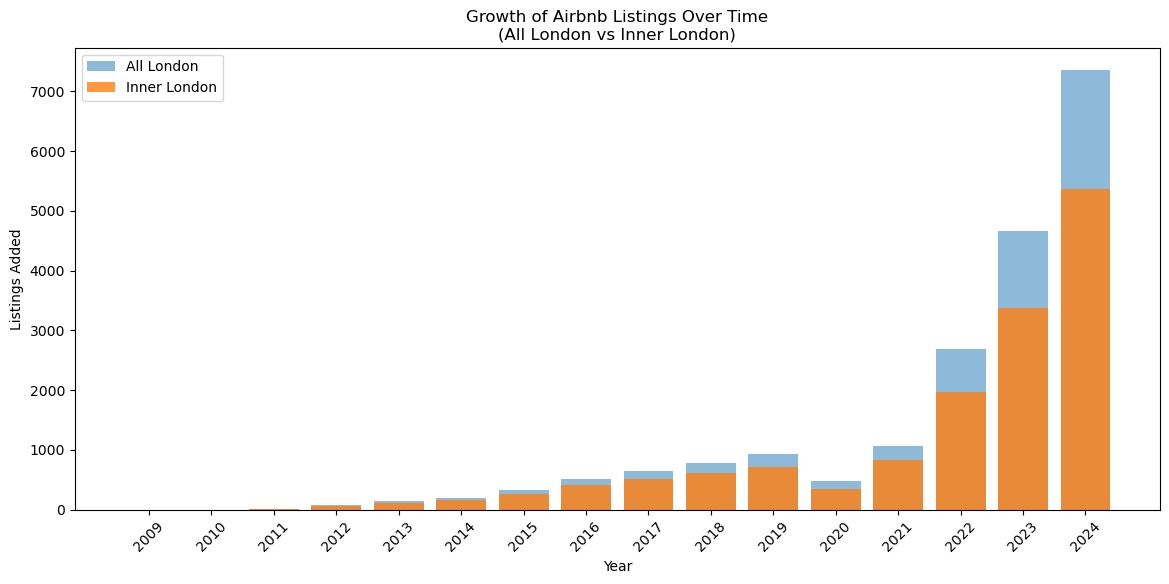

In [20]:
#Step 03: Review the Growth of Airbnb Listings over time, for all of London and specifically for Inner London

# The focus on Inner London is because we hypothesize that most of the new Airbnb listings every year are concentrated in this area.
# Inner London boroughs are characterised by higher housing demand and lower housing supply (fewer housing completions per year)

# Data Limitations: 
#The data does not include the exact date when each listing was first published on the platform. However, it does record the
# date of the first review. Under the assumption that reviews are usually posted shortly after a guest's first stay,
# the year of the first review can be used as a proxy for the year the listing became active.

#Create a new column only with the year of the first review.
listings_sjoin["year_first_review"] = listings_sjoin["first_review"].dt.year.astype("Int64")


# Define the boroughs that belong to inner London 
inner_london = [
    "Camden",
    "Greenwich",
    "Hackney",
    "Hammersmith and Fulham",
    "Islington",
    "Kensington and Chelsea",
    "Lambeth",
    "Lewisham",
    "Southwark",
    "Tower Hamlets",
    "Wandsworth",
    "Westminster",
    "City of London"
]

# Create a df only for inner London
df_inner = listings_sjoin[
    listings_sjoin["lad11nm"].isin(inner_london)
].copy()

# Count the number of listings by year in all of London and Inner London
# Excludes 2025 as the data for the current year is incomplete
count_all = listings_sjoin[listings_sjoin["year_first_review"] != 2025]["year_first_review"].value_counts().sort_index()
count_inner = df_inner[df_inner["year_first_review"] != 2025]["year_first_review"].value_counts().sort_index()


# Plot: Airbnb listings added per year in All London vs Inner London
plt.figure(figsize=(14,6))


# Bars for all London
plt.bar(
    count_all.index.astype(str),
    count_all.values,
    label="All London",
    alpha=0.5
)

# Bars for inner London overlapping
plt.bar(
    count_inner.index.astype(str),
    count_inner.values,
    label="Inner London",
    alpha=0.8
)

plt.xlabel("Year")
plt.ylabel("Listings Added")
plt.title("Growth of Airbnb Listings Over Time\n(All London vs Inner London)")
plt.legend()
plt.xticks(rotation=45)

plt.show()
# ---- Output data ----
# df_inner: A df containing listings located only in the boroughs of Inner London
# ---- Output Figure ----
# Figure 01: Histogram of the Growth of Airbnb Listings over the years
#            (all London vs Inner London) to see the impact on Inner London, where the housing demand is much higher.

**Summary Figure 01** 
>According to the London Plan Annual Monitoring Report 2022–23 (Greater London Authority, 2025), annual housing completions in London have shown relatively limited variation in recent years. Between 2018 and 2023, net housing completions averaged approximately 36,600 homes per year, with fluctuations of only a few thousand units across the period. This contrasts sharply with the rapid growth of Airbnb supply. In 2023, Airbnb added around 5000 new listings, and in 2024 this figure rose to more than 7,200, representing the equivalent of 13.8% to 20% of London’s yearly housing production. These proportions highlight that the rapid expansion of short-term rentals is effectively undermining the impact of London’s efforts to increase housing supply. Even as thousands of new homes are completed each year, a significant share appears to be absorbed into the Airbnb market rather than contributing to long-term housing availability.
>
> https://www.london.gov.uk/programmes-strategies/planning/implementing-london-plan/monitoring-london-plan

#### **Figure 02** | Growth of Airbnb Listings

In [21]:
listings_sjoin.columns

Index(['id', 'name', 'host_id', 'host_is_superhost',
       'host_total_listings_count', 'neighbourhood_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'bedrooms', 'accommodates',
       'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'first_review', 'last_review',
       'review_scores_rating', 'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month',
       'estimated_revenue_l365d', 'estimated_occupancy_l365d', 'geometry',
       'index_right', 'msoa11cd', 'msoa11nm', 'lad11cd', 'lad11nm', 'rgn11cd',
       'rgn11nm', 'usualres', 'hholdres', 'comestres', 'pop

In [23]:
# Step 04: Percentage of full-time listings out of total households by MSOA

# Produce a normalised indicator of Airbnb intensity by calculating the proportion of full-time, entire-home listings relative to the total number of households in each MSOA. 
#This allows comparison across areas with different population sizes and reveals where Airbnb activity may exert stronger pressure on local housing supply.
# Count how many listings fall in each MSOA
listing_counts = listings_sjoin.groupby("msoa11nm").size()

# Merge the MSOA geometry from the GeoPackage with the household data so that each polygon includes the number of households in that area.
msoa_merged = msoa.merge(housing, left_on="msoa11nm", right_on="msoa_name")
msoa_merged = msoa_merged[["msoa_name", "households_2011all_households", "geometry"]]
msoa_merged = msoa_merged.to_crs(epsg=27700)
# Merge the listing counts back into the MSOA GeoDataFrame
msoa_merged = msoa_merged.merge(
    listing_counts.reset_index(name="listing_counts"),
    on="msoa_name",
    how="left"
)

# Calculate the percentage of Airbnb listings relative to households per MSOA
msoa_merged["percentage"] = (msoa_merged["listing_counts"] / msoa_merged["households_2011all_households"]*100)


#Plot map 

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

msoa_merged.plot(
    ax=ax,
    column="percentage",
    cmap="OrRd",
    scheme="NaturalBreaks",
    k=5,
    linewidth=0,
    legend=True,
    legend_kwds={
    "title": "",
    "fmt": "{:,.0f}"  # string, not method
}
)

# Make it look cleaner
ax.set_axis_off()
ax.set_title("Percentage of fulltime listings out of total households by MSOA", fontsize=14)

plt.show()

# ---- Output Figure ----
# Figure 02: Choropleth map visualising the percentage of full-time Airbnb 
#            entire-home listings relative to total households per MSOA.


KeyError: 'msoa_name'

**Summary Figure 02** 
> Conclusions from the map The map reveals a highly asymmetric spatial distribution of illegal Airbnb Activity in London. In contrast, most MSOAs in Outer London, show minimun levels of illegal Airbnb Activity. This suggests that Airbnb is not "out of control" everywhere, but is concentrated in central, high demand areas. (This parragraph needs more work)
> Some of the darkest MSOAs—particularly in the City of London and a few central districts—reflect very high percentages of full-time Airbnb listings relative to local households.
This does not necessarily indicate unusually high Airbnb activity; rather, these areas have very small residential populations and low household counts. These values should therefore be interpreted with caution.

In [24]:
# Step 05: Clean rent dataset (Could this be moved to data cleaning section? is a short code)

# Limitations: 
# We were only able to find current rental information at the borough level, not at the MSOA level.
# As a result, the analysis must be conducted using a larger spatial unit than originally intended. 

rent = rent.replace(["..", "-"], pd.NA)

numeric_cols = ["count_of_rents", "mean", "lower_quartile", "median", "upper_quartile"]

for col in numeric_cols:
    rent[col] = pd.to_numeric(rent[col], errors="coerce")

rent.head(7)

# ---- Output data ----
# rent: the data frame now cleaned

,borough,bedroom_category,count_of_rents,mean,lower_quartile,median,upper_quartile
0,Barking and Dagenham,Room,10.0,514.0,NaN,559.0,NaN
1,Barking and Dagenham,Studio,10.0,892.0,800.0,838.0,981.0
2,Barking and Dagenham,One Bedroom,180.0,1187.0,1050.0,1200.0,1300.0
3,Barking and Dagenham,Two Bedrooms,280.0,1416.0,1250.0,1415.0,1550.0
4,Barking and Dagenham,Three Bedrooms,180.0,1657.0,1500.0,1625.0,1850.0
5,Barking and Dagenham,Four or More Bedrooms,20.0,2112.0,1796.0,2200.0,2500.0
6,Barnet,Room,20.0,682.0,612.0,626.0,676.0


Smith (1979) first proposed the
rent gap model to offer a structural explanation for gentrification in American inner-city
contexts such as New York City and Philadelphia. At its core, the rent gap model describes a
situation where the actual economic returns to properties tend to decline or stagnate while
potential economic returns tend to increase. In neighborhoods where this “gap” between
actual and potential returns systematically increases, the result will be a correspondingly
increasing incentive for real estate capital to direct new housing investment flows. As these
investment flows drive up housing prices, attract more affluent newcomers, and displace
existing poorer residents, the result is gentrification.

In [25]:
# Step 06: Classify the listings by bedroom category for comparability 
#          with the rental dataset

# This classification allows direct comparison between:
#   - the supply of Airbnb listings by bedroom type, and
#   - the distribution of long-term rental properties by bedroom type.

# It will also enable bedroom-specific analyses of rent gaps .

# Create a function to convert numeric bedroom counts into categorical labels . 
def map_bedroom_category(n):
    if pd.isna(n):
        return "Unknown"
    n = int(n)
    if n <= 0:
        return "Studio"
    elif n == 1:
        return "One Bedroom"
    elif n == 2:
        return "Two Bedrooms"
    elif n == 3:
        return "Three Bedrooms"
    else:
        return "Four or More Bedrooms"

# Apply the classification to the listings dataset
listings_fulltime["bedroom_category"] = listings_fulltime["bedrooms"].apply(map_bedroom_category)

# Review the result
listings_fulltime["bedroom_category"].value_counts()

bedroom_category
One Bedroom              14089
Two Bedrooms             10341
Three Bedrooms            3908
Four or More Bedrooms     2350
Studio                    1439
Unknown                     79
Name: count, dtype: int64

In [26]:
# Step 07: Spatial Join Airbnb revenue estimates by borough shapefile


# Reproject to Britain National Grid
borough_shp = borough_shp.to_crs(epsg=27700)


# Create a subset of listings_fulltime, with the listings that comply with the conditions to evaluate monthly revenue
# (1) Estimated revenue > 0 - removes listings that are inactive or not generating revenue
# (2) Estimated occupancy 365 > 60 - This threshold removes listings that operate only sporadically or at very low levels of activity. 
#     Filtering them out ensures that the revenue estimates represent listings that are genuinely operating 
#     as part of the short-term rental market and can therefore be compared more meaningfully with long-term rents.

listings_filtered = (
    listings_fulltime[
        (listings_fulltime["estimated_revenue_l365d"] > 0) &
        (listings_fulltime["estimated_occupancy_l365d"] >= 60)  ##### Check this value, could be 90, but I'm being conservative
    ]
).copy()

# Create estimated monthly revenue (annual revenue divided by 12)
listings_filtered["monthly_revenue"] = listings_filtered["estimated_revenue_l365d"] / 12

#Spatial join: assign each filtered listing to its borough polygon
listings_sjoin = gpd.sjoin(
    listings_filtered,
    borough_shp,
    how="left",
    predicate="within"
)

# Calculate mean monthly revenue by borough and bedroom category
mean_revenue = (
    listings_sjoin
    .groupby(["borough_name", "bedroom_category"])["monthly_revenue"]
    .mean()
    .reset_index()
)

# Convert to wide format (bedroom categories as columns)
mean_revenue_wide = mean_revenue.pivot(
    index="borough_name",
    columns="bedroom_category",
    values="monthly_revenue"
).reset_index()


#Merge revenue table back into the borough shapefile
borough_revenue = borough_shp.merge(
    mean_revenue_wide,
    on="borough_name",
    how="left"
)

# Remove the 'Unknown' bedroom category (not meaningful for comparison)
borough_revenue = borough_revenue.drop(columns=["Unknown"])

# Rename columns for consistency, as we are later adding the revenue of private rent 
borough_revenue = borough_revenue.rename(columns={
    "Studio": "studio_airbnb",
    "One Bedroom": "one_bedroom_airbnb",
    "Two Bedrooms": "two_bedroom_airbnb",
    "Three Bedrooms": "three_bedroom_airbnb",
    "Four or More Bedrooms": "fourplus_airbnb"
})

# Standardise borough name field
borough_revenue = borough_revenue.rename(columns={"borough_name": "borough_clean"})



# Exclude the City of London (we dont have private rental data for this borough)
borough_revenue = borough_revenue[
    ~borough_revenue["borough_clean"] .isin([
        "city and county of the city of london",
        "city of westminster"
    ])
]
borough_revenue.head()

,borough_code,geometry,borough_clean,fourplus_airbnb,one_bedroom_airbnb,studio_airbnb,three_bedroom_airbnb,two_bedroom_airbnb
1,E09000002,"POLYGON ((545714.899 181642.305, 545678.901 18...",barking and dagenham,1713.250000,1345.537037,NaN,1128.689394,1587.562500
2,E09000003,"POLYGON ((523293.197 186457.696, 523239.2 1865...",barnet,2808.733333,1231.520202,862.280303,2235.176829,1846.464506
3,E09000004,"POLYGON ((547962.296 170556.398, 547957.399 17...",bexley,2594.218750,910.533951,1280.833333,1335.226190,1206.765152
4,E09000005,"POLYGON ((521058.398 183113.004, 521051.002 18...",brent,3512.745370,2114.983696,1434.705128,2979.898148,2265.484568
5,E09000006,"POLYGON ((540344.998 157603.096, 540339.803 15...",bromley,3242.950000,1244.176768,1624.900000,2186.525000,1472.783333


In [27]:
# Step 08: Merge rent data with the borough shapefile and the 
#    borough-level Airbnb revenue estimates.
 
# Align long-term rental prices with Airbnb  revenue estimates at the borough level.

# Standardise the borough name to ensure a correct merge
rent["borough_clean"] = rent["borough"].str.lower().str.strip()

# Convert to wide format (bedroom categories as columns)
rent_wide = rent.pivot(
    index="borough_clean",
    columns="bedroom_category",
    values="mean"
).reset_index()

# Drop room category, as we are working with entire units
rent_wide = rent_wide.drop(columns=["Room"])

# Rename columns for consistency, 
rent_wide = rent_wide.rename(columns={
    "Studio": "studio_rent",
    "One Bedroom": "one_bedroom_rent",
    "Two Bedrooms": "two_bedroom_rent",
    "Three Bedrooms": "three_bedroom_rent",
    "Four or More Bedrooms": "fourplus_rent"
})

# Merge the rental data with borough-level Airbnb revenue estimates
revenue_airbnb_rent = borough_revenue.merge(
    rent_wide,
    on="borough_clean",
    how="left")


# Identify all numeric columns that should not be strings
cols_to_fix = [
    "studio_rent", "one_bedroom_rent", "two_bedroom_rent",
    "three_bedroom_rent", "fourplus_rent",
    "studio_airbnb", "one_bedroom_airbnb", "two_bedroom_airbnb",
    "three_bedroom_airbnb", "fourplus_airbnb"
]

# Convert all to numeric (strings → numbers, invalid → NaN)
for col in cols_to_fix:
    revenue_airbnb_rent[col] = pd.to_numeric(
        revenue_airbnb_rent[col], errors="coerce"
    )
    
revenue_airbnb_rent.head()

# ---- Output data ----
# revenue_airbnb_rent : Consolidates the two sources or the housing market at a borough scale:
#       (1) estimated Airbnb monthly revenue, disaggregated by bedroom category
#       (2) mean long-term private rental prices, disaggregated by bedroom category
#       This dataset enables direct comparison between the two categories.



,borough_code,geometry,borough_clean,fourplus_airbnb,one_bedroom_airbnb,studio_airbnb,three_bedroom_airbnb,two_bedroom_airbnb,fourplus_rent,one_bedroom_rent,studio_rent,three_bedroom_rent,two_bedroom_rent
0,E09000002,"POLYGON ((545714.899 181642.305, 545678.901 18...",barking and dagenham,1713.250000,1345.537037,NaN,1128.689394,1587.562500,2112.0,1187.0,892.0,1657.0,1416.0
1,E09000003,"POLYGON ((523293.197 186457.696, 523239.2 1865...",barnet,2808.733333,1231.520202,862.280303,2235.176829,1846.464506,3174.0,1378.0,1062.0,2176.0,1657.0
2,E09000004,"POLYGON ((547962.296 170556.398, 547957.399 17...",bexley,2594.218750,910.533951,1280.833333,1335.226190,1206.765152,1782.0,1173.0,836.0,1586.0,1397.0
3,E09000005,"POLYGON ((521058.398 183113.004, 521051.002 18...",brent,3512.745370,2114.983696,1434.705128,2979.898148,2265.484568,3150.0,1958.0,1700.0,2525.0,2343.0
4,E09000006,"POLYGON ((540344.998 157603.096, 540339.803 15...",bromley,3242.950000,1244.176768,1624.900000,2186.525000,1472.783333,2619.0,1198.0,968.0,1883.0,1497.0


#### **Figure 03** | Scatterplot Airbnb vs Private Rent Monthly revenue by bedroom category

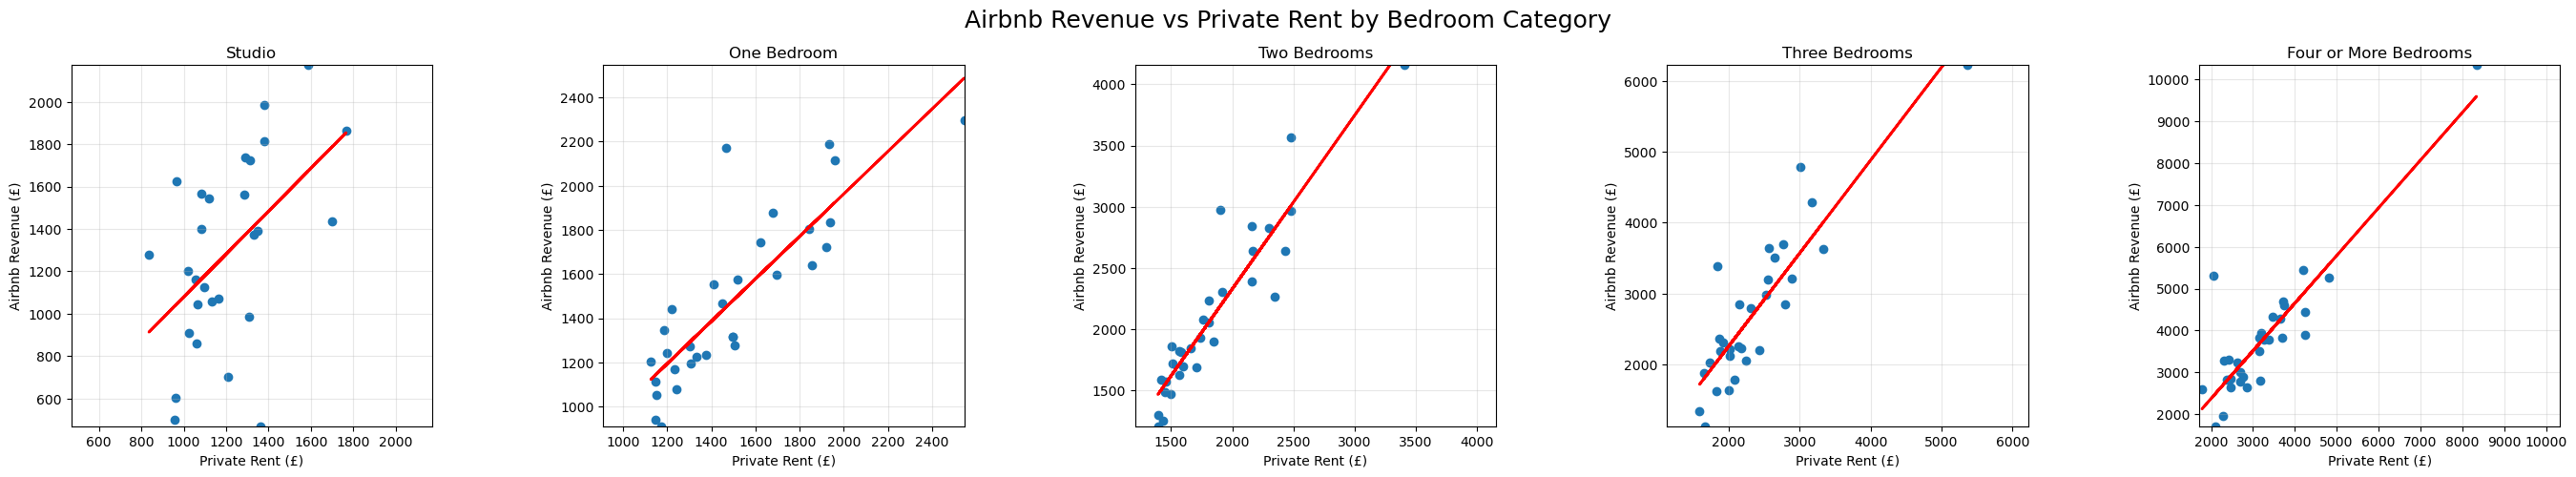

In [28]:
# Step 08: Produce scatterplots comparing Airbnb monthly revenue and 
#    private rents by bedroom category

# Dictionary linking categories to column names
categories = {
    "Studio": ("studio_rent", "studio_airbnb"),
    "One Bedroom": ("one_bedroom_rent", "one_bedroom_airbnb"),
    "Two Bedrooms": ("two_bedroom_rent", "two_bedroom_airbnb"),
    "Three Bedrooms": ("three_bedroom_rent", "three_bedroom_airbnb"),
    "Four or More Bedrooms": ("fourplus_rent", "fourplus_airbnb")
}

# Define figure with 5 subplots
fig, axes = plt.subplots(1, 5, figsize=(28, 5))

for ax, (cat, (rent_col, airbnb_col)) in zip(axes, categories.items()):
    
    # Numeric conversion
    x = pd.to_numeric(revenue_airbnb_rent[rent_col], errors="coerce")
    y = pd.to_numeric(revenue_airbnb_rent[airbnb_col], errors="coerce")

    # Scatter plot
    ax.scatter(x, y)

    # Compute regression line
    valid = ~(x.isna() | y.isna())
    x_valid = x[valid]
    y_valid = y[valid]

    if len(x_valid) > 1:
        m, b = np.polyfit(x_valid, y_valid, 1)
        # Draw regression
        ax.plot(x_valid, m*x_valid + b, color="red", linewidth=2)

    # Equal axis scaling within each category
    
    type_min = min(x_valid.min(), y_valid.min())
    type_max = max(x_valid.max(), y_valid.max())

    ax.set_xlim(type_min, type_max)
    ax.set_ylim(type_min, type_max)
    ax.set_aspect("equal", "box")
    # --------------------------------------------------

    # Labels & styling
    ax.set_title(cat, fontsize=12)
    ax.set_xlabel("Private Rent (£)")
    ax.set_ylabel("Airbnb Revenue (£)")
    ax.grid(alpha=0.3)

plt.suptitle("Airbnb Revenue vs Private Rent by Bedroom Category", fontsize=18)
plt.tight_layout()
plt.show()


# ---- Output figure ----
#  Figure 03: Scatterplot Airbnb Revenue vs Private Rent by Bedroom Category 

**Summary Figure 03** 
>The scatter plots show that while studios and one-bedroom units have similar returns in Airbnb and the private rental market, larger units (2–4+ bedrooms) generate significantly higher Airbnb revenue. This indicates stronger financial incentives to convert family-sized homes into short-term rentals.

In [29]:
#  Calculate the slopes to enable precise comparison between the 5 categories
slopes = {}

for cat, (rent_col, airbnb_col) in categories.items():
    
    # Force numeric (avoid dtype errors)
    x = pd.to_numeric(df[rent_col], errors="coerce")
    y = pd.to_numeric(df[airbnb_col], errors="coerce")
    
    valid = ~(x.isna() | y.isna())
    x_valid = x[valid]
    y_valid = y[valid]
    
    # Compute slope only if there are enough points
    if len(x_valid) > 1:
        m, b = np.polyfit(x_valid, y_valid, 1)
        slopes[cat] = m
    else:
        slopes[cat] = np.nan

slopes

NameError: name 'df' is not defined

#### **Figure 04** | Rent Gap (Airbnb vs Private Rent) Two Bedroom Units

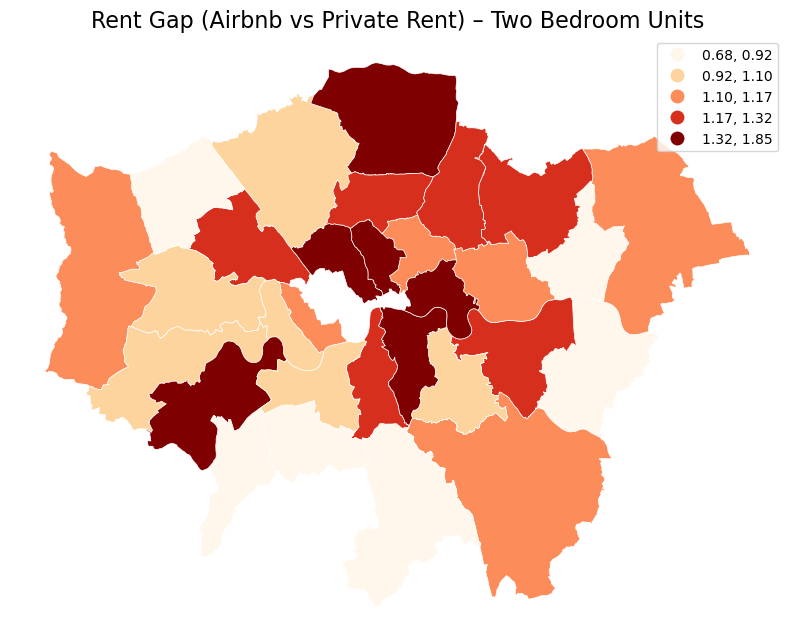

In [30]:
# Step 10: Map the rent gap (Airbnb revenue / private rent) for two-bedroom units 
#    across London boroughs.

# The rent gap is calculated as the ratio between the average monthly
# Airbnb revenue and average private rent for the same unit size.
# Values > 1 indicate that Airbnb is more profitable than renting 
# long-term, revealing boroughs where incentives to convert homes 
# into short-term rentals are strongest.

# Calculate the rent gap for three-bedroom units
revenue_airbnb_rent["rentgap_three_bedroom"] = (
    revenue_airbnb_rent["three_bedroom_airbnb"] /
    revenue_airbnb_rent["three_bedroom_rent"]
)

# Plot the spatial distribution of the rent gap
revenue_airbnb_rent.plot(
    column="rentgap_three_bedroom",
    cmap="OrRd",
    scheme="Quantiles",
    k=5,
    linewidth=0.5,
    edgecolor="white",
    legend=True,
    figsize=(10,10)
)
plt.title("Rent Gap (Airbnb vs Private Rent) – Two Bedroom Units", fontsize=16)
plt.axis("off")
plt.show()

# ---- Output figure ----
#  Figure 04: Cloropeth map of Rent Gap (airbnb vs private rent) in two-bedroom units

**Summary Figure 04** 
> This map shows the spatial distribution of the rent gap—defined as the ratio between Airbnb monthly revenue and private rent—for two-bedroom units across London boroughs. The pattern is concentrated in central and high-demand boroughs, suggesting greater market pressure on family-sized housing in these areas.
> Boroughs are very large areas, and the rent gap can change a lot inside the same borough. So this map shows the general pattern, but not the smaller local differences.

#### **Figure 02** | Rent gap in Camden, by bedroom category

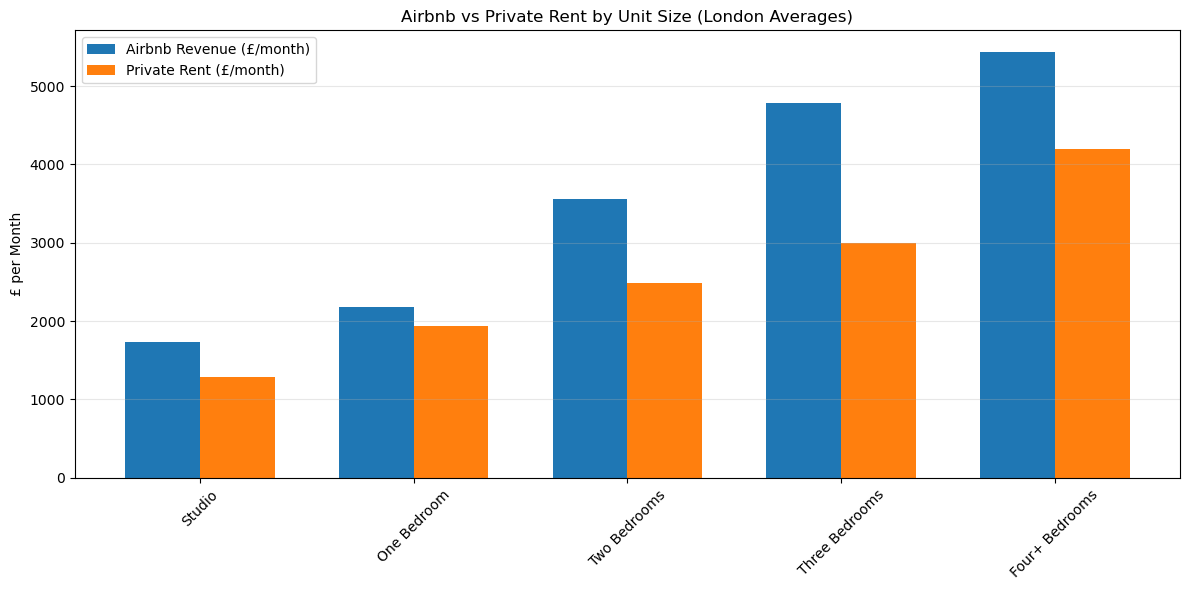

In [31]:
# Step 11: Zoom in on a high-pressure borough, Camden in this case, to compare 
#     Airbnb revenue and private rent by unit size and illustrate 
#     local rent gaps in more detail.


df = revenue_airbnb_rent

# Choose borough
borough = "camden"   # <--- cambia aquí

# Filter borough row
row = df[df["borough_clean"] == borough].iloc[0]

# Tipologías y columnas asociadas
categories = ["Studio", "One Bedroom", "Two Bedrooms", "Three Bedrooms", "Four+ Bedrooms"]

airbnb_cols = [
    "studio_airbnb",
    "one_bedroom_airbnb",
    "two_bedroom_airbnb",
    "three_bedroom_airbnb",
    "fourplus_airbnb"
]

rent_cols = [
    "studio_rent",
    "one_bedroom_rent",
    "two_bedroom_rent",
    "three_bedroom_rent",
    "fourplus_rent"
]

# Extract values for this borough
airbnb_values = row[airbnb_cols].values
rent_values = row[rent_cols].values

# Plot
x = np.arange(len(categories))
width = 0.35

plt.figure(figsize=(12,6))

plt.bar(x - width/2, airbnb_values, width, label="Airbnb Revenue (£/month)")
plt.bar(x + width/2, rent_values, width, label="Private Rent (£/month)")

plt.xticks(x, categories, rotation=45)
plt.ylabel("£ per Month")
plt.title("Airbnb vs Private Rent by Unit Size (London Averages)")
plt.legend()
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

# ---- Output figure ----
#  Figure 05: Scatterplot Airbnb Revenue vs Private Rent by Bedroom Category 

**Summary Figure 04** 
> In a high demand , center located neighborhood like Camden, Airbnb earns more than private rent across all unit sizes.
>For two-bedroom homes, Airbnb brings in around £1,000 more per month (about +35%).
>For three-bedroom homes, the gap is even larger, Airbnb earns roughly £1,800 extra per month (around +60%).

Under London’s regulatory framework, a property may not be rented out for more than 90 nights a year as short-term rental without applying for a change of use, from residential to temporary acommodation. 

*** it would be good to have an approx stat here on the % of airbnbs that are operating with a temporary accomodation license - presumably almost no listings have this ***

We define short-term rental listings as those which allow a minimum length of stay shorter than 30 nights.
*** It would be great to find a stat here that says x % of airbnbs are used for short term rather than long term rentals to back up our assumptions ***

Although the Inside Airbnb dataset provides calendar data showing the availability of a listing for the next 365 days, it is impossible to assertain whether unavailable nights are as a result of nights being booked out by a guest or nights being 'blacked-out' by the owner. Thus, information on the number of days that listings are being rented out annually is sparse and unreliable. Instead, the following calculation was used to estimate the number of nights that each listing was occupied in the last 12 months:

*** we will make this into a nice equation on quarto***

occupancy in the last 12 months = (number of reviews in the last 12 months)/(percentage of guests that leave reviews)*(average minimum number of nights that guests are able to book for)

Assumptions
- number of reviews in the last 12 months is a proxy for demand (Quattrone SE economy paper & Fradkin 2015)
- 70% of guests leave reviews (Fradkin 2015)
- minimum number of nights is a number inputted by the owner on the app, and this can changed at any time and on a day-to-day basis (based on seasonality, preference,  etc) so might not reflect the situation for the previous 12 months
- Some of calculated last 12 month occupancy was > 365 (possibly because the current minimum number of nights is higher than the true minimum number of nights). We assume that it is plausible to assume 



#### Illegal revenue paragraph

In [32]:
# -- Methodology: Illegal listings and revenue --
# Steps Overview:
# 1. Create a function to calculate estimated occupancy, revenue illegal and revenue illegal revenue per listing
#        *** Output *** 
#        Stat: Estimated illegal revenue earned in the last year
#        Stat: Percent of illegal revenue from entire homes
# 2. Calculate the number (and %) of hosts that contribute to 50% of total illegal revenue
#        *** Output *** 
#        Stat: Number of hosts contributing to 50% of illegal revenue
# 3. Calculate where majority of the illegal revenue is being generated
#        *** Output *** 
#        Stat: Number of boroughs in which 80% of illegal rebenue is generated, and how much of this is in central london

In [33]:
# ------ Step 1: Function to calculate estimated, occupancy revenue and illegal revenue ------------

def calculate_occupancy_and_revenue(
    df,
    min_cutoff, 
    review_rate, 
    min_stay_buffer,
    max_occupancy):

    # -- Step 1.1 --
    # Create a new dataframe (listings_illegal)
    # subset it to the minimum cutoff
    # listings_illegal is a subset of listings which only includes listings where the minimum minimum nights are < 30 days
    # this is taken as an indicator that the listing is available for short term rentals
    listings_illegal = df[df["minimum_minimum_nights"] < min_cutoff].copy()
    
    # -- Step 1.2 --
    # Calculate estimated occupancy for the last twelve months --> occupancy_ltm
    # We use the minimum_minimum_nights (inputted by the host) here as conservative estimate for the minimum number of days that the listing was occupied in the last 12 months
    # Hosts have general restrictions for the minimum number of nights one can stay at the listing (minimum nights)
    # But these restrictions can be changed by the host so that certain periods have different minimum night restrictions
    # In reality, the number of nights each guest is staying is likely higher than the minimum_minimum_nights
    # This can be controlled by th min_stay_buffer
    listings_illegal["occupancy_ltm"] = (listings_illegal["number_of_reviews_ltm"] / review_rate) * (listings_illegal["minimum_minimum_nights"] + min_stay_buffer)
    
    # Some of the calculated estimated occupancies mayb be very high (with some > 365 which doesn't make sense for an annual estimate)
    # This is likely due to the unreliablitty of 1. number of reviews being a proxy for number of bookings, and 2. minimum_minimum_nights being a proxy for minimum length of stay
    # To account for this, we set a cutoff for the occupancy
    listings_illegal["occupancy_ltm"] = listings_illegal["occupancy_ltm"].clip(upper=max_occupancy)

    # -- Step 1.3 --
    # Calculate estimated annual revenue per listing for the last twelve months
    # It is important to note here that the number of listings without data on price is extremely high
    listings_illegal["revenue_ltm"] = listings_illegal["occupancy_ltm"] * listings_illegal["price"]

    # -- Step 1.4 --
    # Calculate estimated annual illegal revenue per listing (ie only the revenue earned after 90 day limit was exceeded)
    listings_illegal["illegal_revenue_ltm"] = (
    (listings_illegal["occupancy_ltm"] - 90).clip(lower=0)
    * listings_illegal["price"])

    # -- Step 1.5 --
    # Calculating stats
    # Calculating the percentage of illegal listings out of the total
    illegal_rev_count = listings_illegal[listings_illegal["illegal_revenue_ltm"] > 0].shape[0]  # Number of listings for which illegal revenue could be calculated
    rev_count = listings_illegal[listings_illegal["revenue_ltm"] > 0].shape[0]     # Number of listings for with revenue could be calculated
    per_illegal_listings = (illegal_rev_count/rev_count)*100

    # Total illegal airbnb revenue
    illegal_rev_sum = listings_illegal["illegal_revenue_ltm"].sum(skipna=True)

    # Calculating the percentage of illegal listings out of the total
    illegal_rev_for_entire = listings_illegal.loc[
        listings_illegal["room_type"] == 'Entire home/apt',
        'illegal_revenue_ltm'].sum(skipna=True)
    per_illegal_rev_entire = (illegal_rev_for_entire/illegal_rev_sum)*100

    # Other stats (not used but may be relevant)
    # Total number of listings within the subset
    total_count = listings_illegal.shape[0]

    no_reviews = listings_illegal[listings_illegal["number_of_reviews_ltm"] == 0].shape[0]
    # Number of listings for which occupancy could be estimated
    occ_count = listings_illegal[listings_illegal["occupancy_ltm"] > 0].shape[0]

    # Number of listings for which illegal occupancy was calculated
    illegal_occ_count = listings_illegal[listings_illegal["occupancy_ltm"] > 90].shape[0]
    
    # Total airbnb revenue
    rev_sum = listings_illegal["revenue_ltm"].sum(skipna=True)
    
    return listings_illegal, per_illegal_listings, illegal_rev_sum, per_illegal_rev_entire

In [34]:
## Use the function to calculate the amount of revenue and illegal revenue based on conservative estimates of occupancy

listings_illegal, per_illegal_listings, illegal_rev_sum, per_illegal_rev_entire = calculate_occupancy_and_revenue(
    df=listings,
    min_cutoff=30, # we are only considering short-term rentals to be those which are rented out for less than 30 days at a time
    review_rate=0.70, # We assume that 70% of Airbnb guests leave a review based on the findings of previous studies (Fradkin 2015)
    min_stay_buffer=1, # since this is a conservative estimate, we assume that guests which left a review only stayed the minimum number of nights allowed by the host
    max_occupancy=292  # we assume a maximum of 80% occupancy for the year
)

# **** OUTPUT ****
# Need to ask Jon how he expects us to output this in quarto ...
print(f"Percent illegal listings out of total: {per_illegal_listings:,.0f}")
print(f"Total illegal revenue: {illegal_rev_sum:,.0f}")
print(f"Percentage of illegal revenue from entire home: {per_illegal_rev_entire:,.0f}")

Percent illegal listings out of total: 15
Total illegal revenue: 57,954,631
Percentage of illegal revenue from entire home: 69


In [35]:
# ------ Step 2: Calculate the number (and %) of hosts that contribute to 50% of total illegal revenue ------------

# -- Step 2.1 --
# Create a subset for only illegal listings
listings_illegal_only = listings_illegal[listings_illegal["illegal_revenue_ltm"] > 0].copy()

# -- Step 2.2 --
# Group by host ID and calculate each host's illegal revenue
illegal_revenue_by_host = (
    listings_illegal_only
    .groupby("host_id", as_index=False)
    .agg(
        host_illegal_revenue =("illegal_revenue_ltm", "sum"),
    )
)
number_illegal_hosts = illegal_revenue_by_host.shape[0]

# -- Step 2.3 --
# Calculate the number of hosts that make up the top 50% of revenue
sorted_illegal_hosts = illegal_revenue_by_host.sort_values(
    by="host_illegal_revenue", ascending=False
)

# -- Step 2.4 --
# Calculate cumulative sum of illegal revenue
sorted_illegal_hosts["cum_sum"] = sorted_illegal_hosts["host_illegal_revenue"].cumsum()

# -- Step 2.5 --
# Calculate cumulative percentage
total = sorted_illegal_hosts["host_illegal_revenue"].sum()
sorted_illegal_hosts["cum_pct"] = sorted_illegal_hosts["cum_sum"] / total

# -- Step 2.5 --
# Count how many hosts are needed to reach 50%
num_ill_hosts = (sorted_illegal_hosts["cum_pct"] <= 0.50).sum() + 1  # +1 to include the first borough exceeding 80%

# **** OUTPUT ****
print(f"Number of illegal hosts: {number_illegal_hosts}")
print(f"Number of illegal hosts making up 50% revenue: {num_ill_hosts}")

Number of illegal hosts: 3782
Number of illegal hosts making up 50% revenue: 179


In [36]:
# --------- Step 3: Calculate where majority of the illegal revenue is being generated ---------

# -- Step 3.1 --
#Convert listings fulltime df into Geopandas
import geopandas as gpd

listings_illegal = gpd.GeoDataFrame(
    listings_illegal,
    geometry=gpd.points_from_xy(
        listings_illegal.longitude,
        listings_illegal.latitude
    ),
    crs="EPSG:4326"    
)

#Reproject to Britain National Grid
listings_illegal = listings_illegal.to_crs(epsg=27700)

# -- Step 3.2 --
# Spatial join of the listing according to borough and create a group count value for each borough
listings_sjoin = gpd.sjoin(
    listings_illegal,
    borough_shp,
    how="left",
    predicate="within"
)

# -- Step 3.3 --
# Group by borough and calculate the number of illegal listings and their total revenue
illegal_stats_borough = (
    listings_sjoin
    .groupby("borough_code")
    .agg(
        listing_count=("illegal_revenue_ltm", lambda x: (x > 0).sum()),
        illegal_revenue_sum=("illegal_revenue_ltm", "sum")
    )
)

# -- Step 3.4 --
#   Merge the listing_count values (by borough) into the borough GeoDataFrame
illegal_stats_borough = illegal_stats_borough.reset_index()

borough_shp_illegal = borough_shp.merge(
    illegal_stats_msoa,
    on="borough_code",
    how="left"
)

# -- Step 3.5 --
# Calculate the number of boroughs that make up 80% of illegal revenue

# Sort boroughs by illegal_revenue_sum descending
sorted_boroughs = borough_shp_illegal.sort_values(
    by="illegal_revenue_sum", ascending=False
)

# Calculate cumulative sum of illegal revenue
sorted_boroughs["cum_sum"] = sorted_boroughs["illegal_revenue_sum"].cumsum()

# Calculate cumulative percentage
total = sorted_boroughs["illegal_revenue_sum"].sum()
sorted_boroughs["cum_pct"] = sorted_boroughs["cum_sum"] / total

# Count how many boroughs are needed to reach 80%
num_boroughs_80pct = (sorted_boroughs["cum_pct"] <= 0.80).sum() + 1  # +1 to include the first borough exceeding 80%

# sorted_boroughs[0:num_boroughs_80pct]["borough_name"]
# If we run the previous line, we see that all of the boroughs that make up 80% of the revenue are in inner/central london
# Will need to ask Jon about how to incorporate this into quarto

# ***** OUTPUT *****
# 80% of illegal revenue is generated in only 9 boroughs, all of which are in central london

NameError: name 'illegal_stats_msoa' is not defined

**Paragraph for illegal activity**


Under London’s current regulations, a residential property may not be rented out for more than 90 nights per year as a short-term rental without first obtaining planning permission for a “material change of use” from residential to temporary accommodation. We define illegal listings as those which allow short-term rentals (of less than 30 days) and exceed this 90 day limit. Our conservative estimates show that one in every seven listings is involved in illegal Airbnb activity, with at least £58 million in illegal revenue earned in the last year, 70% of which was for entire homes. More interestingly, 50% of the illegal revenue is attributable to only 171 individual hosts (5% of illegal hosts). Illegal Airbnb activity is mainly localised in the city centre, with 80% of illegal activity occurring in only nine boroughs, all of which are located in the city centre. Although illegal activity generates a significant amount of revenue (and this is likely to be much higher), it is concentrated among a small number of hosts and locations, meaning the overall impact across the city is limited.

Comparing social rental prices with Airbnb rates may provide a more accurate picture of housing market pressures... into Nadia's section...

## Question 2: How many professional landlords are there?

Following the literature [1], a professional landlord can be defined by making these three assumptions:

- A professional landlord rents entire homes or apartments.
- A professional landlord owns listings with a high availability per year.
- A professional landlord owns more that 1 listings, since managing 2 or more listings requires time and coordination, which makes it unlikely for this to be just a "side-job".

The filter for landlords renting entire homes/apartments and with high availability, so the next step if to filter multi-listers hosts to get the final count of **professional landlords**.

>[1] Shabrina, Z.; Arcaute, E.; Batty, M. (2022), Airbnb and its potential impact on the London housing market, Urban Studies.

#### **Figure 2.1** | Histogram of number of listings per professional host

In [46]:
# Identify the total number of professional hosts
# Filter the multi-listers from listings with high availability per year that are entire homes or apartments  

host_counts = listings_filtered["host_id"].value_counts()
prof_land = host_counts[host_counts > 1]

print(f"There are {host_counts.count()} in total, and {prof_land.count()} are professional landlords")

# ---- Output Data -----
# Total number of professional landlords
# host_counts = count of the number of listings per landlord
# prof_land = number of professional landlords 

There are 5522 in total, and 1300 are professional landlords


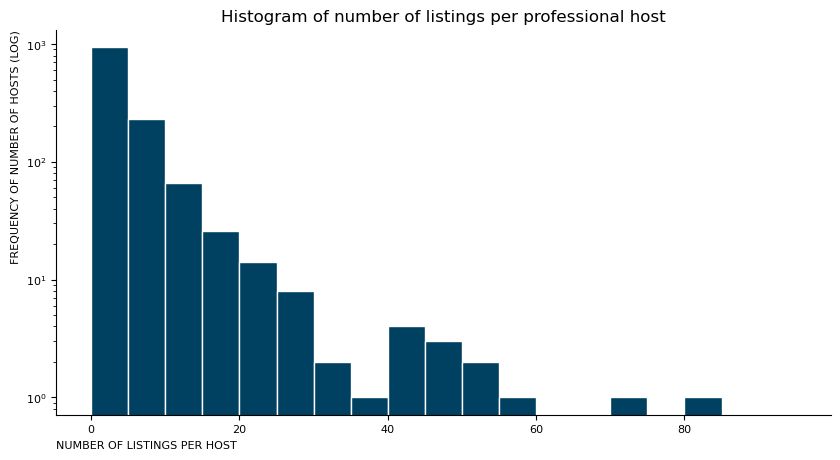

In [47]:
# Create a Histogram explaining the frequency of the number of hosts with the number of listings per host
# Using a log scale to normalize the frequency calculation 

bins = list(range(0, 100, 5)) #Define bins

plt.figure(figsize=(10,5))

plt.hist(prof_land.values, 
         bins=bins, 
         edgecolor='white', 
         color="#004060")

plt.yscale('log')

ax = plt.gca() #Take tHe current ax

ax.spines['top'].set_visible(False) #Get rid of innecesarie lines
ax.spines['right'].set_visible(False) #Get rid of innecesarie lines

ax.set_xlabel("NUMBER OF LISTINGS PER HOST", 
              loc='left', 
              fontsize=8)
ax.set_ylabel("FREQUENCY OF NUMBER OF HOSTS (LOG)", 
              loc='top', 
              fontsize=8)
ax.set_title("Histogram of number of listings per professional host")
ax.tick_params(axis='both', labelsize=8) #Fontsize for axis numbers

plt.show()

# Histogram of the distribution of the number of listings per professional landlord

According to our assumptions, there are **5 522 professional hosts**, and it looks like most of them have less than 60 listings. The hosts with more listings are excepmtions, but it's still important to include them in the analysis since these cases are a signal that the system is, as mentioned before, "out of control"

**Following from the Output:** 

Knowing which ones are the professional landlords would help deepen into finding how do they operate in the system. A way to do this is by:

- Calculating the estimated revenue per host in a year
- Plotting the spatial distribution of the top 6 professional hosts by number of listings.
- Finding if the number of listings per professional host is correlated with being a "superhost"[2], a sign of high-quality service

These outcomes help reveal whether their activity is driven by commercial and profit-oriented practices.

> [2] "What’s required to be a Superhost" (https://www.airbnb.co.uk/help/article/829). Requirements to be a Superhost according to Article:   
> - Experience: At least 10 completed stays (or three stays totalling 100+ nights) which is a sign of consistency  
> - Responsive: Responds quickly to messages (90% response rate) -> a sign of commitment  
> - Three-month criteria: To qualify, these criteria are checked every three months

#### **Figure 2.2** | Distribution of total estimated revenue of professional hosts

In [48]:
# Calculate the amount of revenue per listing in a year
# Extract the professsional landlord from listings_fulltime

prof_ids = prof_land.index 

# Define columns to keep
cols_prof = ['id','host_id','host_is_superhost','estimated_revenue_l365d','geometry']

# Make the filter
listings_prof = listings_filtered.loc[
    listings_filtered["host_id"].isin(prof_ids),
    cols_prof].copy()

# Plot
listings_prof

# ---- Output Data -----
# A dataframe with the listings of the professional landlords only and the estimated revenue of each listing per year

,id,host_id,host_is_superhost,estimated_revenue_l365d,geometry
0,264776,1389063,False,32670.0,POINT (537737.328 173423.242)
3,264779,1389063,False,9216.0,POINT (537484.993 173470.956)
8,264789,1389063,False,26180.0,POINT (537615.211 173464.455)
130,81410,441494,False,105315.0,POINT (529188.011 181915.213)
138,311768,871053,False,47190.0,POINT (528624.778 170373.168)
...,...,...,...,...,...
92767,1409199335305518080,362852046,False,29640.0,POINT (518935.005 185805.372)
93237,1410155157162992896,220521332,False,13380.0,POINT (530056.755 180839.12)
93521,1414378739226519296,23346804,True,20400.0,POINT (546138.117 166030.511)
94241,1420179462175970304,23346804,True,32640.0,POINT (546220.933 166227.644)


In [49]:
# Calculate the amount of revenue per host in one year
# Sum revenue per professional host in pounds £

prof_rev = (listings_prof.groupby("host_id")
    .agg(n_listings=("id", "nunique"),
         is_superhost=("host_is_superhost", "max"),
         total_est_revenue=("estimated_revenue_l365d", "sum")
    )
    .reset_index()
    .sort_values(by="total_est_revenue", ascending=False))

# ---- Output Data -----
# prof_rev: ddataframe including the total revenue per professional landlord

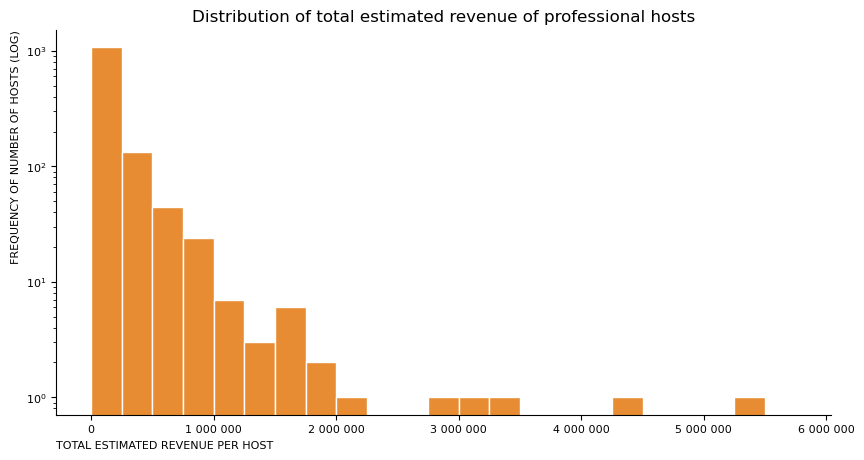

In [50]:
# Histogram explaining the distribution of the total estimated revenue per professional landlord
# Using a log scale to normalize the frequency calculation 

bins = list(range(0, 6000000, 250000)) #Define bins

plt.figure(figsize=(10,5))

plt.hist(prof_rev['total_est_revenue'].values, 
         bins=bins, 
         edgecolor='white', 
         color="#E78C33")

plt.yscale('log')

ax = plt.gca() #Take tHe current ax

ax.xaxis.set_major_formatter(plt.
    FuncFormatter(lambda x, pos: f"{int(x):,}".
        replace(",", " "))) #Formating the numbers

ax.spines['top'].set_visible(False) #Get rid of innecesarie lines
ax.spines['right'].set_visible(False) #Get rid of innecesarie lines

ax.set_xlabel("TOTAL ESTIMATED REVENUE PER HOST", 
              loc='left', 
              fontsize=8)
ax.set_ylabel("FREQUENCY OF NUMBER OF HOSTS (LOG)", 
              loc='top', 
              fontsize=8)
ax.set_title("Distribution of total estimated revenue of professional hosts")
ax.tick_params(axis='both', labelsize=8) #Fontsize for axis numbers

plt.show()

# ---- Output Data -----
# A histogram of the distributions of the revenues per professional landlord

#### **Figure 2.3** | Spatial distribution of the listings of the top6 professional landlords with the most listings

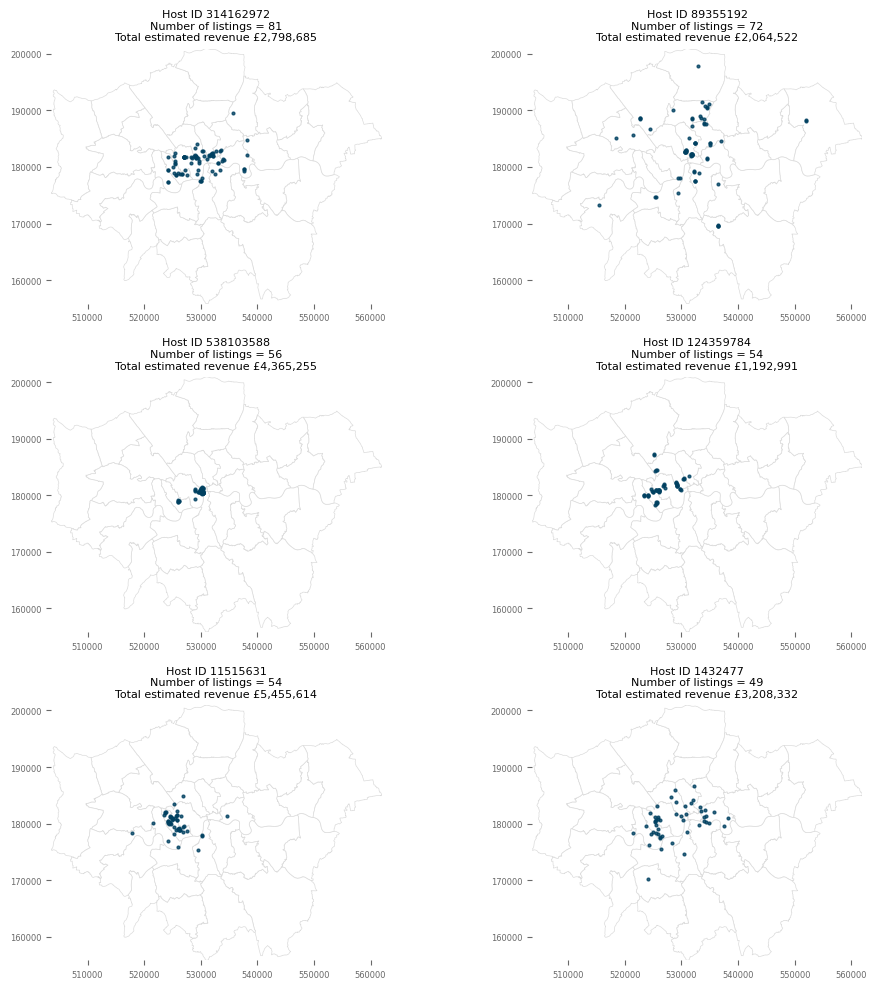

In [51]:
# Plot the spatial distribution of the top 6 professional hosts by number of listings.

# Picking the top 6 professional hosts random hosts to plot
# Keep the information about number of listings and total estimated revenue

prof_top6 = (prof_rev
    .set_index("host_id")
    .sort_values(by="n_listings", ascending=False)
    .head(6)                            
)

#Extract the spatial attributes of the top 10 professional hosts
listings_prof6 = listings_prof[listings_prof["host_id"]
    .isin(prof_top6.index)].copy()

import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

# To make sure all the maps share the same frame
xmin, ymin, xmax, ymax = borough_shp.total_bounds

# Loop for each of the top 6 hosts for subplots
for ax, (host_id, row) in zip(axes.flat, prof_top6.iterrows()):
    n_list = row["n_listings"]
    revenue = row["total_est_revenue"]
    
    # subset listings for this host
    sub = listings_prof6[listings_prof6["host_id"] == host_id]

    # Boundaries for context
    borough_shp.plot(
        edgecolor="Gainsboro",
        facecolor="white",
        linewidth=0.5,
        ax=ax
    )
    
    # Listings as points for every host
    sub.plot(
        ax=ax,
        markersize=4,
        color="#004060",
        alpha=0.8,
        legend=False
    )

    ax.set_title(
        f"Host ID {host_id}\n"
        f"Number of listings = {n_list}\n"
        f"Total estimated revenue £{revenue:,.0f}",
        fontsize=8
    )
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.tick_params(axis="both", labelsize=6, color="dimgray", labelcolor="dimgray")

    ax.spines['top'].set_visible(False) #Get rid of innecesarie lines
    ax.spines['bottom'].set_visible(False) #Get rid of innecesarie lines
    ax.spines['right'].set_visible(False) #Get rid of innecesarie lines
    ax.spines['left'].set_visible(False) #Get rid of innecesarie lines

plt.tight_layout()
plt.show()

# ---- Output Data -----
# Spatial distribution of the top 6 professional landlords with the most number of listings

#### **Figure 2.4** | Correlation between the superhost condition and the number of listings

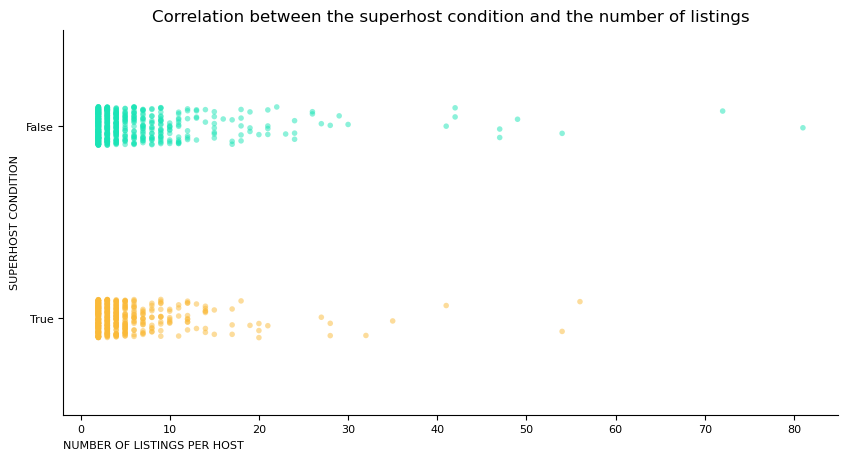

In [52]:
# Finding if the number of listings per professional host is correlated with being a "superhost"
# Create a strip plot

import seaborn as sns

plt.figure(figsize=(10,5))

sns.stripplot(
    data=prof_rev,
    x="n_listings",     
    y="is_superhost",    
    hue="is_superhost",
    alpha=0.5,
    size=4,
    palette="turbo",
    orient="h")

ax = plt.gca() #Take tHe current ax

ax.spines['top'].set_visible(False) #Get rid of innecesarie lines
ax.spines['right'].set_visible(False) #Get rid of innecesarie lines

ax.set_xlabel("NUMBER OF LISTINGS PER HOST", 
              loc='left', 
              fontsize=8)
ax.set_ylabel("SUPERHOST CONDITION", 
              loc='center', 
              fontsize=8)
ax.set_title("Correlation between the superhost condition and the number of listings")
ax.tick_params(axis='both', labelsize=8) #Fontsize for axis numbers

plt.gca().legend_.remove()
plt.show()

# ---- Output Data -----
# A boxplot of the distribution of the the number of listings under the superhost condition per professional landlord

In [53]:
# Calculate Pearson correlation

from scipy.stats import pearsonr

corr_coef, p_value = pearsonr(prof_rev['n_listings'], prof_rev['is_superhost'])
print("Pearson correlation coefficient:", corr_coef)
print("Two-tailed p-value:", p_value)

# ---- Output Data -----
# Pearson's correlation coefficient: two close to zero -> no correlation 
# p-value: lower than 0.05 -> statistically significant

Pearson correlation coefficient: -0.0626968142709852
Two-tailed p-value: 0.02378307977083164


The plots are showing us that the listings of the top 6 professional landlords are spread across London, with some of them being clustered around the central area and in high value boroughs. This spatial distribution, plus the portafolio size and total estimated revenue for all the listings, indicates that some of these hosts are actually comercial operators and not just individuals sharing their houses as the original porpouse of AirBnb was.

In simple terms, our analysis shows that having many Airbnb listings does not mean a host provides better service. This means that having an extensive portfolio does not necessarily indicate higher-quality service, and that the number of listings is more driven by a commercial, and veru profitable as seen in the analysis, business model.

---

#### **Question 3: How many properties would be affected by the opposition’s proposal?**

This question looks at **professional full-time entire-home Airbnb listings only**, attaches each listing to its borough’s and accordingly the average council tax, in order evaluate several listings affected by the oppsional propusal of increasing the council tax, we are applting a **40% council tax increase** as a stndard value of growth (140%) to estimate how many properties see a drop in profit.

##### add 80% revnue we will ignore it for this

**The workflow:** clean and merge council tax with borough polygons, filterise the listings, spatially join listings to boroughs, compare average annual revenue vs average council tax by borough, then simulate a 40% tax rise and calculate profit loss per listing before aggregating to borough level.

**Datasets used:** MAYBE MOVE THIS

>**1. Professional landlord listings (from Q2)**
    - Issues:
        - Not all listings have an estimated annual revenue, so they are removed from the calculation.
        - Not all listings are profitable from the beginning, so once subtracting council tax,
      they aren't profitable. And removed from analysis because they have negative values. 

>**2. Borough boundaries (spatial file)**
    - Issues:
        - The boundaries should be deselected and have an output for the actual borough boundary to merge with council tax.

>**3. Borough-level council tax**
    - Issues:
        - The file has been selected by the year 2024-2025 and only filtered to Band D, which the GLA references as a starting point to evaluate the overall borough tax.
        - The value that we extract is associated with the annual tax *(column Band D, which we later rename as council tax).*

In [54]:
# -- The Work Mythology For evaluating How many properties would be affected by the opposition’s proposal:--
# Steps Overview:
# 1. Cleaning and aligning the Council Tax CSV to prepare for a merge.
# 2. Merge Council Tax Into Borough Shapefile.
# 4. Cleaning and Filtering Listings according to mythology to locate a Professional Landlord, per Q2.
# 5. Spatial Join Listings to Borough Tax Data.
# 6. Calculate Borough Averages: of Airbnb annual Revenue vs Council Tax.
# 7. Evaluate Average Airbnb Revenue vs Average Council Tax per Borough. 
#    Output: Figure 01
# 8. Create a Scenario that increases Council Tax by 40% for Professional Hosts, with the increase varying by borough.
# 9. The borough's share of listings is losing >40% of its profit.
# 10. Linear Relationship Between Revenue and Profit Loss.
#    Output:  **Figure 02** 
# 11. Spatial Point Map of the listings that have had more than 40% loss of profit.
#    Output: **Figure 03**
# 12. Map of Average Profit Loss per Borough.
#    Output: **Figure 04**

In [58]:
# Step 01 - Cleaning and Aligning Council Tax CSV to prepare for merge

# Rename columns in council tax for easy reading
council_tax2 = council_tax.rename(columns={
    'local_authority': 'borough_name_raw',
    'band_d': 'council_tax',
    'code': 'borough_code'})

# Make sure the borough code is a string
council_tax2['borough_code'] = (
    council_tax2['borough_code']
    .astype(str)
    .str.strip())

# make sure council_tax is numeric, (what was yearly band D)
council_tax2['council_tax'] = pd.to_numeric(council_tax2['council_tax'], errors='coerce')

# drop rows where council_tax is missing value 
council_tax2 = council_tax2.dropna(subset=['council_tax'])

# Print Output of row columns and top 5 head of the rows
print("clean council tax:", council_tax2.shape)
display(council_tax2.head())

# ---- Output Data -----
# council_tax2 = Which is a cleaned and renamed version of council_tax

clean council tax: (33, 3)


,borough_code,borough_name_raw,council_tax
1,E09000001,City of London,1217.89
2,E09000002,Barking & Dagenham,2002.75
3,E09000003,Barnet,1943.24
4,E09000004,Bexley,2155.04
5,E09000005,Brent,2036.05


In [59]:
# Step 2 - Merge Council Tax Into Borough Shapefile

# Merge the shape file borough_shp with council_tax2 through a left join with the borough code value as a shared id
borough_tax = borough_shp.merge(
    council_tax2[['borough_code', 'council_tax']],
    on='borough_code',
    how='left'
)

print("borough_tax merged:", borough_tax.shape)
print("missing council tax:", borough_tax['council_tax'].isna().sum()) # make sure that all boundries have been attributed council tax
display(borough_tax.head())

# ---- Output Data -----
# borough_tax = Merged spatial file with council tax data

borough_tax merged: (33, 4)
missing council tax: 0


,borough_code,geometry,borough_name,council_tax
0,E09000001,"POLYGON ((532715.002 180519.596, 532684.396 18...",city and county of the city of london,1217.89
1,E09000002,"POLYGON ((545714.899 181642.305, 545678.901 18...",barking and dagenham,2002.75
2,E09000003,"POLYGON ((523293.197 186457.696, 523239.2 1865...",barnet,1943.24
3,E09000004,"POLYGON ((547962.296 170556.398, 547957.399 17...",bexley,2155.04
4,E09000005,"POLYGON ((521058.398 183113.004, 521051.002 18...",brent,2036.05


In [61]:
# Step 04 - Clean & Filter Listings for Full-Time Entire Homes
##################33 use this # prof_land = number of professional landlords 
##########3 and nadia+emily variable
# Ensure numeric columns just because the data has been used beforehand ######
num_cols = [
    'availability_365',
    'estimated_occupancy_l365d',
    'estimated_revenue_l365d',
    'host_total_listings_count',
    'latitude',
    'longitude'
]

for col in num_cols:
    listings[col] = pd.to_numeric(listings[col], errors='coerce')

# Normalise room_type #######3
listings['room_type'] = listings['room_type'].str.lower().str.strip()

# Professional host flag ####
listings['is_professional_host'] = listings['host_total_listings_count'] > 1


#### Maybe starts From Here

# Keep only columns needed for Q3
cols_needed = [
    'id',
    'host_id',
    'latitude',
    'longitude',
    'price',
    'availability_365',
    'estimated_occupancy_l365d',
    'estimated_revenue_l365d',
    'host_total_listings_count',
    'room_type',
    'is_professional_host'
]
# Create a Copy named listings_q3
listings_q3 = listings[cols_needed].copy()

# Make sure rows with missing IDs are dropped (Extra Safety)
before_id_drop = len(listings_q3) # text output
listings_q3 = listings_q3.dropna(subset=['id', 'host_id'])
after_id_drop = len(listings_q3) # text output
removed_id_rows = before_id_drop - after_id_drop # How many listings with na values have we droped? Hopefully 0
print(f"Removed {removed_id_rows} rows with missing id/host_id")

# Drop rows with missing coordinates (can't map/join them)
before_coord_drop = len(listings_q3) # text output
listings_q3 = listings_q3.dropna(subset=['latitude', 'longitude'])
after_coord_drop = len(listings_q3) # text output
removed_coord_rows = before_coord_drop - after_coord_drop # How many listings with na values have we droped? Hopefully 0
print(f"Removed {removed_coord_rows} rows with missing coordinates")

# Filter to entire homes only according to mythology in Q2 ##############
listings_entire = listings_q3[
    listings_q3['room_type'] == "entire home/apt"
].copy()

# Filter to full-time (90+ days available) according to mythology in Q2 ###########
listings_fulltime = listings_entire[
    listings_entire['availability_365'] > 90 
].copy()

# Explicit annual revenue column from Airbnb data #########^^^^^
# The Column is calculated by Airbnb (the price per night multiplied by the estimated occupancy out of 365 days).
# We treat the estimated 365-day revenue as annual revenue 
listings_fulltime['annual_revenue'] = listings_fulltime['estimated_revenue_l365d']

print("full-time entire homes:", listings_fulltime.shape)
display(listings_fulltime.head())

# ---- Output Data -----
# listings_q3 = contains Airbnb listing data cleaned and filtered by columns only for Q3
# listings_entire = Subset 1 of listings_q3 filtered by entire home and apartment
# listings_fulltime = Subset 2 from listings_entire filtered by availability for more than 90 days

Removed 0 rows with missing id/host_id
Removed 0 rows with missing coordinates
full-time entire homes: (32616, 12)


,id,host_id,latitude,longitude,price,availability_365,estimated_occupancy_l365d,estimated_revenue_l365d,host_total_listings_count,room_type,is_professional_host,annual_revenue
0,264776,1389063,51.44306,-0.01948,297.0,293,110,32670.0,12,entire home/apt,True,32670.0
1,264777,1389063,51.44284,-0.01997,98.0,318,37,3626.0,12,entire home/apt,True,3626.0
2,264778,1389063,51.44359,-0.02275,148.0,302,55,8140.0,12,entire home/apt,True,8140.0
3,264779,1389063,51.44355,-0.02309,144.0,328,64,9216.0,12,entire home/apt,True,9216.0
4,264780,1389063,51.44333,-0.02307,157.0,255,37,5809.0,12,entire home/apt,True,5809.0


In [62]:
# Step 05 - Spatial Join Listings to Borough Tax Data (clean)

# Make sure borough_tax CRS is correct according to World Geodetic System 1984
borough_tax = borough_tax.to_crs(epsg=4326) 

###########3reproject to the other

# Filter listings_fulltime to the London bounding box
# First, calculate the bounding box by maximum and minimum values of the borough boundaries
minx, miny, maxx, maxy = borough_tax.total_bounds

in_london_bbox = (
    (listings_fulltime['longitude'] >= minx) &
    (listings_fulltime['longitude'] <= maxx) &
    (listings_fulltime['latitude']  >= miny) &
    (listings_fulltime['latitude']  <= maxy)
)

print("full-time listings total:", len(listings_fulltime))
print("full-time listings inside London bbox:", in_london_bbox.sum())

# make sure all listings point are within the bounding box
listings_fulltime_london = listings_fulltime[in_london_bbox].copy()

# Create GeoDataFrame from these listings within the London bounding box
listings_gdf = gpd.GeoDataFrame(
    listings_fulltime_london.copy(),
    geometry=gpd.points_from_xy(
        listings_fulltime_london.longitude,
        listings_fulltime_london.latitude
    ),
    crs="EPSG:4326"
)

# Spatial join using within the same as in the previous methods 
# taking the borough geometry and evaluating which points are within which boroughs, 
# and assigning to each point its borough value and accordingly its annual council tax.
listings_gdf = gpd.sjoin(
    listings_gdf,
    borough_tax[['borough_code', 'borough_name', 'council_tax', 'geometry']],
    how='left',
    predicate='within'
)

print("after spatial join:", listings_gdf.shape)
print("listings missing council tax after join:",
      listings_gdf['council_tax'].isna().sum())

# drop unmatched listings
# points that weren't matched with a borough would be lost
rows_before = listings_gdf.shape[0] 
listings_gdf = listings_gdf.dropna(subset=['council_tax']).copy()
rows_after = listings_gdf.shape[0]
print("dropped unmatched listings:", rows_before - rows_after)
print("after dropping unmatched listings:", listings_gdf.shape)

display(listings_gdf.head())

# Quick visual check
# ax = borough_tax.plot(edgecolor='black', facecolor='none', figsize=(6, 6))
listings_gdf.sample(1000, random_state=1).plot(ax=ax, markersize=1)

# ---- Output Data -----
# listings_fulltime_london = only points located inside the London Bounding Box
# listing_gdf = geo-dataframe containing listing points and their attributes, boroughs, and council tax.

full-time listings total: 32616
full-time listings inside London bbox: 32616
after spatial join: (32616, 17)
listings missing council tax after join: 0
dropped unmatched listings: 0
after dropping unmatched listings: (32616, 17)


,id,host_id,latitude,longitude,price,availability_365,estimated_occupancy_l365d,estimated_revenue_l365d,host_total_listings_count,room_type,is_professional_host,annual_revenue,geometry,index_right,borough_code,borough_name,council_tax
0,264776,1389063,51.44306,-0.01948,297.0,293,110,32670.0,12,entire home/apt,True,32670.0,POINT (-0.01948 51.44306),22,E09000023,lewisham,2037.98
1,264777,1389063,51.44284,-0.01997,98.0,318,37,3626.0,12,entire home/apt,True,3626.0,POINT (-0.01997 51.44284),22,E09000023,lewisham,2037.98
2,264778,1389063,51.44359,-0.02275,148.0,302,55,8140.0,12,entire home/apt,True,8140.0,POINT (-0.02275 51.44359),22,E09000023,lewisham,2037.98
3,264779,1389063,51.44355,-0.02309,144.0,328,64,9216.0,12,entire home/apt,True,9216.0,POINT (-0.02309 51.44355),22,E09000023,lewisham,2037.98
4,264780,1389063,51.44333,-0.02307,157.0,255,37,5809.0,12,entire home/apt,True,5809.0,POINT (-0.02307 51.44333),22,E09000023,lewisham,2037.98


<Axes: title={'center': 'Correlation between the superhost condition and the number of listings'}, xlabel='NUMBER OF LISTINGS PER HOST', ylabel='SUPERHOST CONDITION'>

In [63]:
# Step 06 -  Borough Averages: Revenue vs Council Tax

# Create a Copy of the file just for this Summary (Safety Reasons)
listings_for_summary = listings_gdf.copy()

# Group the listings by Borough, calculate new values for the number of listings per borough, Average annual revenue, and average council tax per borough. 
borough_summary = (
    listings_for_summary
    .groupby(['borough_code', 'borough_name'], as_index=False)
    .agg(
        avg_airbnb_revenue=('annual_revenue', 'mean'),  # average revenue
        avg_council_tax=('council_tax', 'mean'),        # average council tax
        n_listings=('id', 'count')                      # number of listings
    )
    .sort_values('avg_airbnb_revenue', ascending=False) # affects the plot
)

print("borough_summary shape:", borough_summary.shape)
display(borough_summary.head())


# ---- Output Data -----
# borough_summary = is a summarized table of revenue,tax, and listing per borough.

borough_summary shape: (33, 5)


,borough_code,borough_name,avg_airbnb_revenue,avg_council_tax,n_listings
32,E09000033,city of westminster,21414.269781,975.02,5497
19,E09000020,kensington and chelsea,17048.512718,1529.85,3342
6,E09000007,camden,15940.091736,2010.87,2480
18,E09000019,islington,14610.936429,1920.81,1455
0,E09000001,city and county of the city of london,13351.229226,1217.89,353


#### **Figure 01** | Average Airbnb Revenue vs Average Council Tax per Borough 

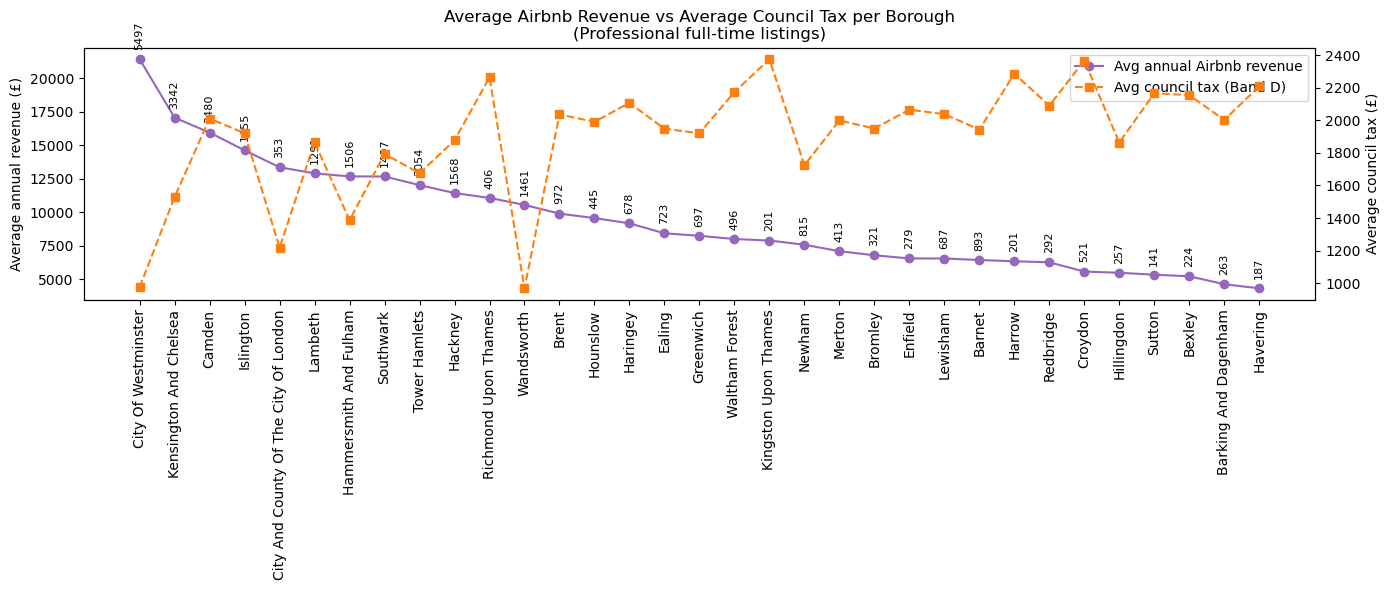

In [64]:
# Step 07 - Figure 01
# A combined line and point graph comparing:
#   (1) Average annual Airbnb revenue per borough
#   (2) Average council tax per borough (Band D)
#   (3) Number of professional full-time listings per borough 
# The x-axis is ordered by borough_summary (currently sorted by number of listings).

# Prep the x-axis labels and positions
# Convert borough names to Title for neat labels.
x_labels = borough_summary['borough_name'].str.title().tolist()

# Create a numeric position for each borough on the x-axis.
x_pos = np.arange(len(x_labels))

# Extract the series we want to plot from the summary table:
rev_vals = borough_summary['avg_airbnb_revenue'].values   # average annual revenue per borough
tax_vals = borough_summary['avg_council_tax'].values      # average council tax per borough
n_vals   = borough_summary['n_listings'].values           # number of listings per borough

# Create the base figure and first axis (for revenue)
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot Line 1: Average Airbnb revenue per borough (left y-axis)
rev_line = ax1.plot(
    x_pos,
    rev_vals,
    marker='o',
    color='tab:purple',
    label='Avg annual Airbnb revenue.'
)[0]

# Label the left y-axis for revenue and set the borough names on the x-axis.
ax1.set_ylabel('Average annual revenue (£)')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(x_labels, rotation=90)

# Create the second axis (for council tax) sharing the same x-axis
ax2 = ax1.twinx()

# Plot Line 2: Average council tax per borough (right y-axis)
tax_line = ax2.plot(
    x_pos,
    tax_vals,
    marker='s',
    linestyle='--',
    color='tab:orange',
    label='Avg council tax (Band D)'
)[0]

# Label the right y-axis for council tax.
ax2.set_ylabel('Average council tax (£)')

# Add the number of listings as text labels above the revenue points
# Calculate a small vertical offset so the labels sit just above the revenue markers.
offset = (rev_vals.max() - rev_vals.min()) * 0.04  # 4% off the revenue range

for x, y, n in zip(x_pos, rev_vals, n_vals):
    ax1.text(
        x,
        y + offset,
        str(n),            # show the count of listings
        ha='center',
        va='bottom',
        fontsize=8,
        rotation=90
    )

# Combined legend for both lines
ax1.legend(
    [rev_line, tax_line],
    ['Avg annual Airbnb revenue', 'Avg council tax (Band D)'],
    loc='upper right'
)

# Final layout and title 
plt.title(
    'Average Airbnb Revenue vs Average Council Tax per Borough\n'
    '(Professional full-time listings)'
)

plt.tight_layout()
plt.show()

# ---- Output Figure ----
# Figure 01: Dual-axis line graph showing how average Airbnb revenue and average council tax
#            vary by borough, with listing counts labelled above each revenue point.

In [65]:
# Step 07b - Text Summary for Figure 01
# A short summary of:
#   (1) Average annual revenue per borough
#   (2) Average council tax per borough
#   (3) Top / bottom revenue boroughs
#   (4) Correlation between revenue and council tax

# Ensure we use the same ordering as Figure 01 (highest to lowest revenue)
borough_summary_rev = (
    borough_summary
    .sort_values('avg_airbnb_revenue', ascending=False)
    .reset_index(drop=True)
)

# 1. Overall averages across all boroughs
overall_rev_mean = borough_summary_rev['avg_airbnb_revenue'].mean()
overall_tax_mean = borough_summary_rev['avg_council_tax'].mean()

# 2. Top 3 and bottom 3 boroughs by average annual revenue
top3 = borough_summary_rev.head(3)
bottom3 = borough_summary_rev.tail(3)

# 3. Simple Pearson correlation between revenue and council tax
#    (Measures whether high-tax boroughs also tend to have high average revenue.)
corr_rev_tax = borough_summary_rev['avg_airbnb_revenue'].corr(
    borough_summary_rev['avg_council_tax']
)

print("!! Summary for Figure 01: Revenue vs Council Tax by Borough !!\n")

# Overall averages
print(f"Overall average annual revenue per listing: £{overall_rev_mean:,.0f}")
print(f"Overall average council tax (Band D):      £{overall_tax_mean:,.0f}\n")

# Top 3 revenue boroughs
print("Top 3 boroughs by average annual Airbnb revenue:")
for _, row in top3.iterrows():
    print(
        f"  - {row['borough_name'].title()}: "
        f"£{row['avg_airbnb_revenue']:,.0f} avg revenue, "
        f"£{row['avg_council_tax']:,.0f} avg council tax, "
        f"{int(row['n_listings'])} listings"
    )

# Bottom 3 revenue boroughs
print("\nBottom 3 boroughs by average annual Airbnb revenue:")
for _, row in bottom3.iterrows():
    print(
        f"  - {row['borough_name'].title()}: "
        f"£{row['avg_airbnb_revenue']:,.0f} avg revenue, "
        f"£{row['avg_council_tax']:,.0f} avg council tax, "
        f"{int(row['n_listings'])} listings"
    )

# The relationship between revenue and tax
print("\nCorrelation between average revenue and average council tax:")
print(
    f"  Pearson r ≈ {corr_rev_tax:.2f}  "
    "(+1 = strong positive, 0 = no linear relationship, -1 = strong negative)"
)

!! Summary for Figure 01: Revenue vs Council Tax by Borough !!

Overall average annual revenue per listing: £9,421
Overall average council tax (Band D):      £1,906

Top 3 boroughs by average annual Airbnb revenue:
  - City Of Westminster: £21,414 avg revenue, £975 avg council tax, 5497 listings
  - Kensington And Chelsea: £17,049 avg revenue, £1,530 avg council tax, 3342 listings
  - Camden: £15,940 avg revenue, £2,011 avg council tax, 2480 listings

Bottom 3 boroughs by average annual Airbnb revenue:
  - Bexley: £5,216 avg revenue, £2,155 avg council tax, 224 listings
  - Barking And Dagenham: £4,625 avg revenue, £2,003 avg council tax, 263 listings
  - Havering: £4,318 avg revenue, £2,208 avg council tax, 187 listings

Correlation between average revenue and average council tax:
  Pearson r ≈ -0.64  (+1 = strong positive, 0 = no linear relationship, -1 = strong negative)


**Summary Figure 01** 
> this shows that average annual revenue (aprox. £9.3k) is much higher than average council tax (aprox. £1.9k). That high-revenue central boroughs (Westminster, Kensington & Chelsea, Camden) tend to have **lower** average council tax. In contrast, low-revenue outer boroughs often face higher taxes and have far fewer listings.

In [66]:
# Step 08 - Council Tax Increase Scenario for Professional Hosts
# In this step, we:
#   1) Compute current net profit (revenue - council tax).
#   2) Apply a +40% council tax scenario.
#   3) Measure how much profit each listing loses in % terms.
#   4) Flag listings that lose more than a chosen threshold (e.g. 40%).

############# go through this after nadia

# Filter only professional full-time entire homes.
# (All subsequent calculations are done only on this group.)
listings_prof = listings_gdf[listings_gdf['is_professional_host']].copy()
print("Number of professional full-time listings:", listings_prof.shape)

# Make sure the key numeric columns are actually numeric.
# This protects us from strings, blanks, etc.
listings_prof['annual_revenue'] = pd.to_numeric(
    listings_prof['annual_revenue'], errors='coerce'
)
listings_prof['council_tax'] = pd.to_numeric(
    listings_prof['council_tax'], errors='coerce'
)

# Drop rows that are missing revenue or council tax and print the outcome
before_na = len(listings_prof)
listings_prof = listings_prof.dropna(subset=['annual_revenue', 'council_tax']).copy()
print("  - Dropped due to missing annual_revenue/council_tax:",
      before_na - len(listings_prof),
      "| remaining:", len(listings_prof))

# ------------------------------------------------------------
# # Current vs increased council tax
# ------------------------------------------------------------

# Current net profit for each listing:
# net_profit_current = annual_revenue - current council tax.
listings_prof['net_profit_current'] = (
    listings_prof['annual_revenue'] - listings_prof['council_tax'])

# Drop listings that are already not profitable BEFORE the tax rise.
# These are not really 'damaged' by the new policy because they were
# not making money to begin with.
before_profit = len(listings_prof)
listings_prof = listings_prof[listings_prof['net_profit_current'] > 0].copy()
print("  - Dropped due to non-positive profit:",
      before_profit - len(listings_prof),
      "| remaining:", len(listings_prof))

# Apply the policy: increase council tax by 40%.
# (Change tax_increase_factor if you want to test another scenario.)
tax_increase_factor = 1.40   # 1.40 = +40%
listings_prof['council_tax_new'] = listings_prof['council_tax'] * tax_increase_factor

# Net profit AFTER the tax increase:
listings_prof['net_profit_new'] = (
    listings_prof['annual_revenue'] - listings_prof['council_tax_new'])

# Absolute loss in profit in £:
listings_prof['profit_loss_abs'] = (
    listings_prof['net_profit_current'] - listings_prof['net_profit_new'])

# Percentage loss in profit relative to original profit:
listings_prof['profit_loss_pct'] = (
    listings_prof['profit_loss_abs'] / listings_prof['net_profit_current'])

# Total number of listings in our profit model (after all filters above)
n_total_prof = len(listings_prof)

# ------------------------------------------------------------
# Threshold-based loss flag (easily changeable)
# ------------------------------------------------------------

# Choose the policy threshold: ##################
# loss_threshold = 0.40  > loses more than 40% of its original profit.
loss_threshold = 0.40

# Flag listings that lose more than this % of their original profit.
listings_prof['loss_over_threshold'] = (
    listings_prof['profit_loss_pct'] > loss_threshold
)

# Count how many professional listings are heavily affected.
n_affected = listings_prof['loss_over_threshold'].sum()

# Share of professional listings that lose more than the threshold.
pct_affected = (n_affected / n_total_prof * 100) if n_total_prof > 0 else np.nan

print(
    f"Listings losing more than {loss_threshold:.0%} of profit: "
    f"{n_affected} out of {n_total_prof} "
    f"({pct_affected:.1f}% of professional full-time listings)"
)

# Easy subset for mapping/plotting later on:
# listings_prof_affected contains only the 'heavily hit' listings.
listings_prof_affected = listings_prof[listings_prof['loss_over_threshold']].copy()

# Quick peek at the first few records used in the profit model.
display(
    listings_prof[
        ['borough_name', 'annual_revenue', 'council_tax', 'council_tax_new',
         'net_profit_current', 'net_profit_new',
         'profit_loss_pct', 'loss_over_threshold']
    ].head()
)

# ---- Output DataFrames ----
# listings_prof:
#   Professional full-time entire-home listings that:
#     - have valid annual_revenue and council_tax

# listings_prof_affected:
#   Subset of listings_prof where loss_over_threshold == True.
#   These are the “heavily hit” professional listings that lose
#   more than 40% of their original profit under the new council tax.

Number of professional full-time listings: (26329, 17)
  - Dropped due to missing annual_revenue/council_tax: 1013 | remaining: 25316
  - Dropped due to non-positive profit: 9800 | remaining: 15516
Listings losing more than 40% of profit: 1839 out of 15516 (11.9% of professional full-time listings)


,borough_name,annual_revenue,council_tax,council_tax_new,net_profit_current,net_profit_new,profit_loss_pct,loss_over_threshold
0,lewisham,32670.0,2037.98,2853.172,30632.02,29816.828,0.026612,False
1,lewisham,3626.0,2037.98,2853.172,1588.02,772.828,0.513339,True
2,lewisham,8140.0,2037.98,2853.172,6102.02,5286.828,0.133594,False
3,lewisham,9216.0,2037.98,2853.172,7178.02,6362.828,0.113568,False
4,lewisham,5809.0,2037.98,2853.172,3771.02,2955.828,0.216173,False


In [67]:
# Step 09 - Borough share of listings losing >40% of profit
# Goal:
#   1) For each borough, count how many professional full-time listings
#      lose more than 40% of their original profit.
#   2) Express this as a percentage of all professional listings
#      in that borough.
#   3) This shows where hosts are *most likely* to be heavily hit
#      by the 40% council tax increase.

# Create a boolean flag for "heavily affected" listings
listings_prof['over_thresh'] = listings_prof['profit_loss_pct'] > loss_threshold

# Borough-level summary of exposure to the policy
borough_impact = (
    listings_prof
    .groupby('borough_name', as_index=False)
    .agg(
        total_listings=('id', 'count'),      # all professional full-time listings
        affected=('over_thresh', 'sum')          # how many lose >40% profit
    )
)

# Convert to percentage of listings in each borough
borough_impact['affected_share_pct'] = (
    borough_impact['affected'] / borough_impact['total_listings'] * 100
).round(1)

# Sort from most exposed borough to least
borough_impact = (
    borough_impact
    .sort_values('affected_share_pct', ascending=False)
    .reset_index(drop=True)
)

display(borough_impact)

# ---- Output table ----
# borough_impact = for each borough:
#   - total_listings: number of professional full-time listings
#   - affected: number of those losing >40% of profit
#   - affected_share_pct: % of listings in that borough that are heavily hit

,borough_name,total_listings,affected,affected_share_pct
0,havering,44,12,27.3
1,lewisham,251,64,25.5
2,enfield,84,20,23.8
3,merton,131,31,23.7
4,greenwich,236,56,23.7
5,barking and dagenham,68,16,23.5
6,croydon,161,37,23.0
7,hillingdon,89,20,22.5
8,bexley,49,11,22.4
9,barnet,343,76,22.2


#### **Figure 02** | Linear Relationship Between Revenue and Profit Loss

Using 14520 listings out of 15516 for the regression plot.


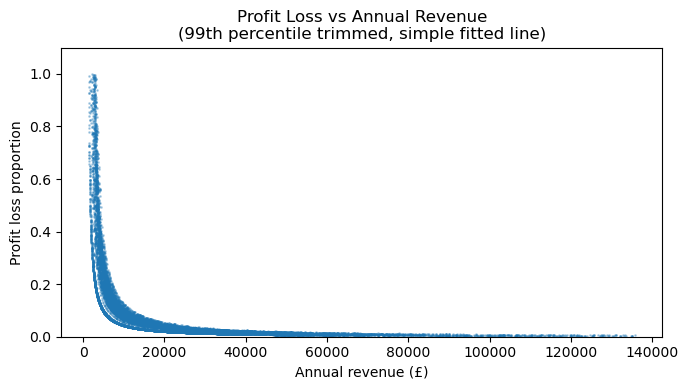

Approx regression: profit_loss_pct ≈ -0.0000 + 0.19469165 * annual_revenue


In [76]:
# Step 10 - Figure 03: Linear Relationship Between Revenue and Profit Loss
# In this step we:
#   1) Trim away extreme revenue outliers (top 1%) so the plot is readable.
#   2) Look only at listings with a sensible profit-loss value (0–100%).
#   3) Scatter-plot annual revenue vs % profit lost.
#   4) Fit a simple straight line (least-squares) just to see if there is
#      any clear linear pattern between revenue level and damage from the tax.

##############33 fix this because there is no line

# Trim extremes so a few huge listings don't dominate the axes
rev_q99 = listings_prof['annual_revenue'].quantile(0.99)

# Keep only:
#   - Revenue below or equal to the 99th percentile
#   - Profit loss between 0 and 1 (0–100%)
mask = (
    (listings_prof['annual_revenue'] <= rev_q99) &
    (listings_prof['profit_loss_pct'] >= 0) &
    (listings_prof['profit_loss_pct'] <= 1)   # 0–100% loss
)

# Extract the x (revenue) and y (loss proportion) for the filtered sample
x = listings_prof.loc[mask, 'annual_revenue'].values
y = listings_prof.loc[mask, 'profit_loss_pct'].values

print(f"Using {mask.sum()} listings out of {len(listings_prof)} for the regression plot.")

# Safety check: only fit a line if we actually have data left
if len(x) > 1:
    # Fit a simple linear regression: y ≈ a + b * x
    # (Minimal, hand-rolled regression to get a line.)
    a, b = np.polyfit(x, y, 1)

    # Plot the scatter and the fitted line
    fig, ax = plt.subplots(figsize=(7, 4))

    # Each point = one professional listing (after trimming)
    ax.scatter(x, y, s=1, alpha=0.3)

    # Generate a smooth line over the observed revenue range
    x_line = np.linspace(x.min(), x.max(), 100)
    ax.plot(x_line, a + b * x_line, linewidth=2)

    ax.set_xlabel('Annual revenue (£)')
    ax.set_ylabel('Profit loss proportion')
    ax.set_title(
        'Profit Loss vs Annual Revenue\n'
        '(99th percentile trimmed, simple fitted line)'
    )

    # Keep y-axis in a sane range; cap around the max observed loss
    ax.set_ylim(0, max(y.max() * 1.1, 0.5))

    plt.tight_layout()
    plt.show()

    # Print the approximate regression equation for interpretation in the text
    print(f"Approx regression: profit_loss_pct ≈ {a:.4f} + {b:.8f} * annual_revenue")
else:
    print("Not enough data after filtering to fit a regression line.")

**Summary Figure 02** 
>(revenue vs % profit loss) shows a non-linear pattern: low-revenue listings can lose up to 100% of their profit, while high-revenue listings are mostly unaffected. Consequently, the tax mainly bites at the bottom rather than the top.

#### **Figure 03** | Spatial Point Map of the listings that have had more than 40% loss of profit

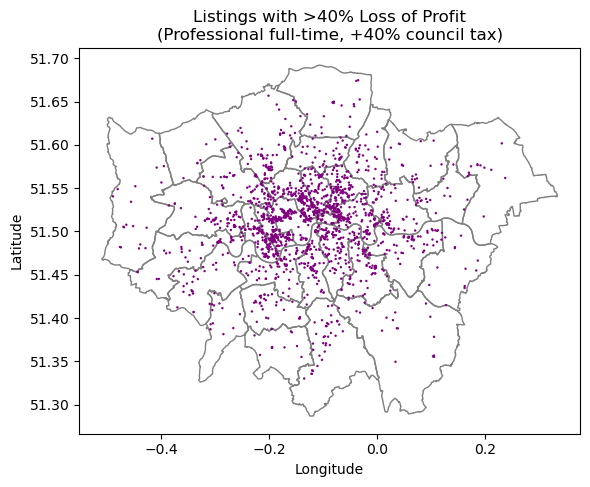

In [77]:
# Step 11 - Figure 03
# Spatial map of the *heavily affected* listings

# In this figure we show:
#   - Only professional full-time listings that lose >40% of their
#     original profit under the +40% council tax scenario
#     (loss_over_threshold == True > listings_prof_affected).
#   - Borough polygons are drawn in the background.
#   - Purple dots show where highly impacted listings are clustered.

fig, ax = plt.subplots(figsize=(6, 6))

# Plot the borough boundaries as a neutral backdrop.
borough_tax.plot(
    ax=ax,
    edgecolor='grey',
    facecolor='none'
)

# Overlay only the "heavily hit" listings (>40% profit loss).
listings_prof_affected.plot(
    ax=ax,
    edgecolor='none',
    facecolor='purple',
    markersize=3
)

# Titles & axes labels.
ax.set_title(
    'Listings with >40% Loss of Profit\n'
    '(Professional full-time, +40% council tax)'
)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.tight_layout()
plt.show()

# ---- Output Figure ----
# Figure 02: Point map of professional full-time listings that lose
#            more than 40% of their original profit, plotted against
#            the London borough boundaries.

In [68]:
# Step 11b - Text summary for borough exposure to >40% profit loss
# Context:
# Where does the 40% council tax increase bite hardest in relative terms?

print("!!Summary for Step 09: Borough exposure to >40% profit loss!!\n")

# Overall numbers across all boroughs:
#   How many professional listings lose >40% of profit in total,
#   and what % of all professional listings that represent.
overall_total = borough_impact['total_listings'].sum()
overall_affected = borough_impact['affected'].sum()
overall_share = overall_affected / overall_total * 100 if overall_total > 0 else float("nan")

print(
    f"Across all boroughs, {overall_affected:,} out of {overall_total:,} "
    f"professional full-time listings lose more than 40% of their original profit."
    f"({overall_share:.1f}% overall).\n"
)

# Top 5 boroughs by share of listings losing >40% of profit
# (not by raw counts, but by % of local hosts heavily hit).
top5 = borough_impact.head(5)

print("Top 5 boroughs by share of listings losing >40% of profit:")
for _, row in top5.iterrows():
    print(
        f"  - {row['borough_name'].title()}: "
        f"{int(row['affected'])} out of {int(row['total_listings'])} listings "
        f"({row['affected_share_pct']:.1f}% heavily affected)"
    )

# Bottom 3 boroughs (least exposed to the policy in % terms).
bottom3 = borough_impact.tail(3)

print("\nBottom 3 boroughs by share of listings losing >40% of profit:")
for _, row in bottom3.iterrows():
    print(
        f"  - {row['borough_name'].title()}: "
        f"{int(row['affected'])} out of {int(row['total_listings'])} listings "
        f"({row['affected_share_pct']:.1f}% heavily affected)"
    )

print(
    "\nThese figures show where the 40% council tax increase *bites hardest* in"
    "relative terms (high affected_share_pct), even if some of those boroughs"
    "do not have the largest absolute number of listings."
)


!!Summary for Step 09: Borough exposure to >40% profit loss!!

Across all boroughs, 1,839 out of 15,516 professional full-time listings lose more than 40% of their original profit.(11.9% overall).

Top 5 boroughs by share of listings losing >40% of profit:
  - Havering: 12 out of 44 listings (27.3% heavily affected)
  - Lewisham: 64 out of 251 listings (25.5% heavily affected)
  - Enfield: 20 out of 84 listings (23.8% heavily affected)
  - Merton: 31 out of 131 listings (23.7% heavily affected)
  - Greenwich: 56 out of 236 listings (23.7% heavily affected)

Bottom 3 boroughs by share of listings losing >40% of profit:
  - Wandsworth: 63 out of 660 listings (9.5% heavily affected)
  - Kensington And Chelsea: 151 out of 1812 listings (8.3% heavily affected)
  - City Of Westminster: 123 out of 3246 listings (3.8% heavily affected)

These figures show where the 40% council tax increase *bites hardest* inrelative terms (high affected_share_pct), even if some of those boroughsdo not have the

**Summary Figure 03** 
> Here we see that about **12% of professional full-time listings** lose more than **40% of their original profit**, with the highest *shares* of heavily affected listings in several outer boroughs, even though the most significant *counts* of affected listings sit in central high-Airbnb areas.

#### **Figure 04** | Map of Average Profit Loss per Borough

,Borough,Number of professional full-time listings,Average profit loss (%),Median profit loss (%)
0,havering,44,37.5,24.5
1,merton,131,29.8,15.9
2,enfield,84,29.8,14.5
3,lewisham,251,29.1,13.4
4,croydon,161,28.8,12.0
5,barking and dagenham,68,28.6,10.9
6,bexley,49,28.5,12.7
7,barnet,343,27.3,11.1
8,sutton,48,27.0,20.0
9,greenwich,236,26.5,10.5


Range of average loss: 7.2% – 37.5%


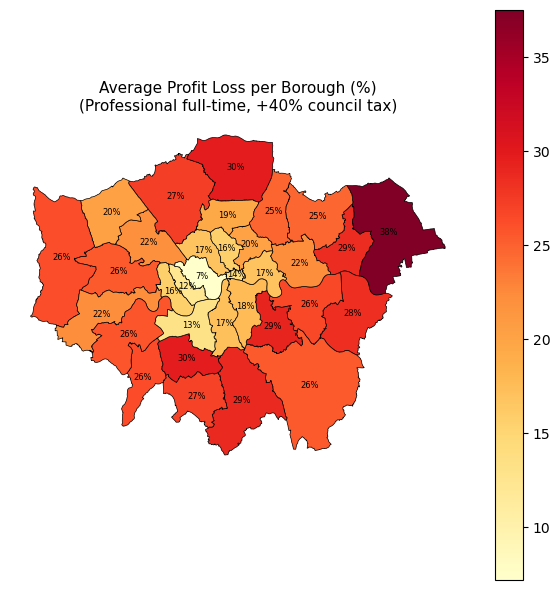

In [79]:
# Step 12 - Average Profit Loss per Borough: Table + Map
#
# Steps:
# Uses the listing-level results from Step 08 (listings_prof with profit_loss_pct).
# Aggregates to the borough level
# Joins those borough-level averages back onto the borough polygons.
# Draws a choropleth map + prints the average % loss on each borough.


# Clip profit_loss_pct to a sensible 0–100% range (0–1 as proportion)
# Avoids weird extreme values dominating the averages.
listings_prof['profit_loss_pct_clipped'] = (
    listings_prof['profit_loss_pct'].clip(lower=0, upper=1)
)

# Borough-level summary of how effective the policy is (on average)
borough_loss_table = (
    listings_prof
    .groupby('borough_name', as_index=False)
    .agg(
        n_listings=('id', 'count'),                         # sample size in borough
        avg_loss_pct=('profit_loss_pct_clipped', 'mean'),   # average loss
        median_loss_pct=('profit_loss_pct_clipped', 'median')  # median loss
    )
)

# Convert proportions to percentages and tidy names
borough_loss_table['avg_loss_pct'] = (
    borough_loss_table['avg_loss_pct'] * 100
).round(1)

borough_loss_table['median_loss_pct'] = (
    borough_loss_table['median_loss_pct'] * 100
).round(1)

borough_loss_table = (
    borough_loss_table
    .rename(columns={
        'borough_name': 'Borough',
        'n_listings': 'Number of professional full-time listings',
        'avg_loss_pct': 'Average profit loss (%)',
        'median_loss_pct': 'Median profit loss (%)'
    })
    .sort_values('Average profit loss (%)', ascending=False)
    .reset_index(drop=True)
)

display(borough_loss_table)

# Join borough polygons to the borough loss table for mapping
borough_loss_map = borough_tax.merge(
    borough_loss_table,
    left_on='borough_name',   # from borough_tax
    right_on='Borough',       # from borough_loss_table
    how='left'
)

# Create a clean column name to plot
borough_loss_map['avg_loss_pct_percent'] = borough_loss_map['Average profit loss (%)']

# Optional: project to a metric CRS for nicer centroids/labels
############33moveup
gdf = borough_loss_map.to_crs(epsg=27700)

fig, ax = plt.subplots(figsize=(6, 6))

# Check the actual range of average % loss across boroughs
vmin = gdf['avg_loss_pct_percent'].min()
vmax = gdf['avg_loss_pct_percent'].max()

print(f"Range of average loss: {vmin:.1f}% – {vmax:.1f}%")

# Draw the choropleth using the real data range 
gdf.plot(
    column='avg_loss_pct_percent',
    cmap='YlOrRd',      
    linewidth=0.5,
    edgecolor='black',
    legend=True,
    vmin=vmin,
    vmax=vmax,
    ax=ax
)

ax.set_axis_off()
ax.set_title(
    "Average Profit Loss per Borough (%)\n"
    "(Professional full-time, +40% council tax)",
    fontsize=11
)

# Add % labels at borough centroids
centroids = gdf.geometry.centroid

for (_, row), point in zip(gdf.iterrows(), centroids):
    if pd.isna(row['avg_loss_pct_percent']):
        continue
    ax.text(
        point.x,
        point.y,
        f"{row['avg_loss_pct_percent']:.0f}%",  # round to whole % for readability
        ha='center',
        va='center',
        fontsize=6,
        color='black'
    )

plt.tight_layout()
plt.show()

# ---- Output Figure ----
# Figure 04: Choropleth map where each borough is shaded by its average

**Summary Figure 04** 
> shows that average profit loss per borough ranges from about **7–20% in central boroughs** up to **30–35% in some outer boroughs**, meaning outer hosts lose roughly a third of profit on average.

**Short General Conclusion on discussion 3:**
> The results suggest a **flat 40% council tax increase is a blunt tool**: it hits a minority of (mostly lower-revenue, outer-London) hosts hard, but **most high-revenue central hosts remain clearly profitable**, so this policy alone is unlikely to strongly reduce professional Airbnb activity without more targeted, income- or listing-based measures.

#### **Question 4: What are the likely pros and cons of the opposition’s proposal (for the Mayor, residents, and the city)?**

The opposition suggests raising council tax for some Airbnb hosts and "professional landlords". Our analysis agrees that Airbnb is part of London's housing problem, but shows that this particular tool/method is uneven.

London is adding about 35k homes per year, while Airbnb adds 5–7.2k new listings a year – roughly 14–20% of annual housing output. A noticeable share of homes is being diverted to short-term lets rather than long-term housing. (citation)
Based on our findings, short-term letting is much more profitable than long-term renting, giving owners a clear financial incentive to convert units to Airbnb. (citation) 

The problem is that "Professional landlords" have multiple entire-home listings and are active across the city, behaving like small hotel firms, not casual hosts. If we take the method of increasing council tax on professional landlords, we saw that under a simulated +40% council tax increase, most professional listings still make a healthy profit. The tax mainly bites lower-revenue hosts in outer boroughs, while high-revenue listings in central areas can easily absorb the change.

**Effects of the opposition proposal for different actors**

**For the Mayor**
>**Pros:**
> - The Mayor can claim he is "Making Airbnb pay more".
> - Brings in some extra revenue that could be directed to enforcement or housing programmes.

>**Cons:**
>- The proposal risks looking symbolic rather than practical.
>- Politically, the proposal can be accused of being all hosts in cheaper areas face pressure, while well-capitalised operators in Westminster, Kensington & Chelsea, or Camden continue essentially unchanged.

**For the Residents:**
>**Pros:**
> - With the proposal, a few marginal listings may revert to long-term rentals, especially when profits are thin.

>**Cons:**
> - The profit gap between Airbnb and long-term renting remains, and we can assume that most landlords will pay the higher tax and carry on.

**For the City:**
>**Pros:**
> - Some listings may disappear from the short-let market due to the proposal, which slightly eases pressure on specific neighbourhoods and pushes some tourist demand back towards hotels.

>**Cons:**
> - The proposal targets council tax bands rather than the fundamental players: revenue and the number of listings per host.

---
**Overall judgement:**

We suggest that the Mayor should agree with the opposition but reject their tool; indicate a policy that would regulate host registration, enforce strict rental duration requirements, and implement primary-residence rules, with penalties for platforms and hosts that do not comply. We see these rules implemented in various cities around the world, such as New York with its Local Law 18 (citation) and Amsterdam with its 30-night cap and primary-residence requirement. (Municipality of Amsterdam, 2025), as well as in Paris, Barcelona, and many more (citation). 

>**This policy can combine revenue-based and volume-based taxation, enforce registration across platforms, impose strict 90-day enforcement, and impose strict bans on letting council and newly built housing. This will get us closer to that international standard and far more likely to shift power away from high-earning professional landlords and back towards residents.**